In [ ]:
# COMBINED INCOME-EXPENSE PROFIT FORECASTING MODEL
# Predicts company profits using XGBoost on both income and expense data

# STEP 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 2: Load Data (MODIFIED TO HANDLE BOTH CSV AND EXCEL)
print("📂 LOADING DATA...")
file_path = "/content/Predictive_Analysis_Final.xlsx" # Original file path
# If you also want to test with the Excel file mentioned in the previous error:
# file_path_excel = "/content/Predictive_Analysis_Final.xlsx"

df = pd.DataFrame() # Initialize an empty DataFrame

if file_path.lower().endswith('.csv'):
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded CSV file: {file_path}")
    except FileNotFoundError:
        print(f"Error: CSV file '{file_path}' not found. Please check the path.")
    except UnicodeDecodeError:
        print(f"Error: Could not decode CSV file '{file_path}' with default encoding. Trying 'latin1'.")
        try:
            df = pd.read_csv(file_path, encoding='latin1')
            print(f"Successfully loaded CSV file with 'latin1' encoding.")
        except Exception as e:
            print(f"Error loading CSV with 'latin1' encoding: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while loading CSV file: {e}")
elif file_path.lower().endswith('.xlsx') or file_path.lower().endswith('.xls'):
    try:
        # You need to install openpyxl: pip install openpyxl
        df = pd.read_excel(file_path, engine='openpyxl')
        print(f"Successfully loaded Excel file: {file_path}")
    except FileNotFoundError:
        print(f"Error: Excel file '{file_path}' not found. Please check the path.")
    except ImportError:
        print("Error: 'openpyxl' library not found. Please install it: pip install openpyxl")
    except Exception as e:
        print(f"An unexpected error occurred while loading Excel file: {e}")
else:
    print(f"Error: Unsupported file format for '{file_path}'. Please use .csv or .xlsx.")

if df.empty:
    print("❌ Dataframe is empty after loading. Exiting.")
    exit()

print(f"Original DataFrame shape: {df.shape}")
print(f"Original DataFrame columns: {df.columns.tolist()}")

# STEP 3: Process Income Data
print("\n🟢 PROCESSING INCOME DATA...")
income_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Income')].copy()
print(f"Income records: {income_df.shape[0]:,}")

if not income_df.empty:
    # Use errors='coerce' to turn unparseable dates into NaT
    income_df['Transaction Date'] = pd.to_datetime(income_df['Transaction Date'], errors='coerce')
    income_df.dropna(subset=['Transaction Date'], inplace=True)
    income_df['Credit - Debit'] = pd.to_numeric(income_df['Credit - Debit'], errors='coerce')
    income_df.dropna(subset=['Credit - Debit'], inplace=True)

    # Daily income aggregation
    daily_income = income_df.groupby('Transaction Date')['Credit - Debit'].sum().reset_index()
    daily_income.columns = ['ds', 'income']

    # Remove income outliers
    if len(daily_income) > 1 and daily_income['income'].std() > 0: # Check to avoid error on single-row/zero-std data
        mean_income = daily_income['income'].mean()
        std_income = daily_income['income'].std()
        daily_income = daily_income[np.abs(daily_income['income'] - mean_income) <= 3 * std_income].copy()
    else:
        print("Skipping income outlier removal due to insufficient data or zero standard deviation.")

    print(f"Daily income data points: {len(daily_income):,}")
    print(f"Average daily income: ₹{daily_income['income'].mean():,.2f}")
else:
    daily_income = pd.DataFrame(columns=['ds', 'income'])
    print("⚠️ No income data found!")

# STEP 4: Process Expense Data
print("\n🔴 PROCESSING EXPENSE DATA...")
expense_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Expense')].copy()
print(f"Expense records: {expense_df.shape[0]:,}")

if not expense_df.empty:
    expense_df['Transaction Date'] = pd.to_datetime(expense_df['Transaction Date'], errors='coerce')
    expense_df.dropna(subset=['Transaction Date'], inplace=True)
    expense_df['Debit - Credit'] = pd.to_numeric(expense_df['Debit - Credit'], errors='coerce')
    expense_df.dropna(subset=['Debit - Credit'], inplace=True)

    # For expenses, use absolute values
    expense_df['Expense Amount'] = expense_df['Debit - Credit'].abs()

    # Daily expense aggregation
    daily_expense = expense_df.groupby('Transaction Date')['Expense Amount'].sum().reset_index()
    daily_expense.columns = ['ds', 'expense']

    # Remove expense outliers
    if len(daily_expense) > 1 and daily_expense['expense'].std() > 0: # Check to avoid error on single-row/zero-std data
        mean_expense = daily_expense['expense'].mean()
        std_expense = daily_expense['expense'].std()
        daily_expense = daily_expense[np.abs(daily_expense['expense'] - mean_expense) <= 3 * std_expense].copy()
    else:
        print("Skipping expense outlier removal due to insufficient data or zero standard deviation.")

    print(f"Daily expense data points: {len(daily_expense):,}")
    print(f"Average daily expense: ₹{daily_expense['expense'].mean():,.2f}")
else:
    daily_expense = pd.DataFrame(columns=['ds', 'expense'])
    print("⚠️ No expense data found!")

# STEP 5: Combine Income and Expense Data
print("\n💰 COMBINING INCOME & EXPENSE DATA...")

# Create date range covering both datasets
if not daily_income.empty and not daily_expense.empty:
    start_date = min(daily_income['ds'].min(), daily_expense['ds'].min())
    end_date = max(daily_income['ds'].max(), daily_expense['ds'].max())
elif not daily_income.empty:
    start_date = daily_income['ds'].min()
    end_date = daily_income['ds'].max()
elif not daily_expense.empty:
    start_date = daily_expense['ds'].min()
    end_date = daily_expense['ds'].max()
else:
    print("❌ No data available for processing income or expense! Cannot combine.")
    exit()

# Create complete date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
daily_combined = pd.DataFrame({'ds': date_range})

# Merge income and expense data
daily_combined = daily_combined.merge(daily_income, on='ds', how='left')
daily_combined = daily_combined.merge(daily_expense, on='ds', how='left')

# Fill missing values with 0
daily_combined['income'] = daily_combined['income'].fillna(0)
daily_combined['expense'] = daily_combined['expense'].fillna(0)

# Calculate daily profit
daily_combined['profit'] = daily_combined['income'] - daily_combined['expense']

print(f"Combined dataset shape: {daily_combined.shape}")
print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Average daily profit: ₹{daily_combined['profit'].mean():,.2f}")
print(f"Total profit in period: ₹{daily_combined['profit'].sum():,.2f}")

# STEP 6: Enhanced Feature Engineering for Profit Prediction
def create_profit_features(df):
    df = df.copy()

    # Basic date features
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter

    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Business calendar features
    df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)
    df['is_fy_end'] = (df['month'] == 3).astype(int)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Days from important dates
    df['days_from_month_start'] = df['day'] - 1
    df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']

    # Lag features for all components
    for component in ['income', 'expense', 'profit']:
        for lag in [1, 2, 3, 7, 14, 30, 90]:
            df[f'{component}_lag_{lag}'] = df[component].shift(lag)

    # Rolling statistics for all components
    for component in ['income', 'expense', 'profit']:
        for window in [7, 14, 30, 90]:
            df[f'{component}_rolling_mean_{window}'] = df[component].rolling(window, min_periods=1).mean().shift(1)
            df[f'{component}_rolling_std_{window}'] = df[component].rolling(window, min_periods=1).std().shift(1)
            df[f'{component}_rolling_max_{window}'] = df[component].rolling(window, min_periods=1).max().shift(1)
            df[f'{component}_rolling_min_{window}'] = df[component].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    for component in ['income', 'expense', 'profit']:
        df[f'historical_month_{component}'] = df.groupby('month')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df[f'historical_quarter_{component}'] = df.groupby('quarter')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df[f'historical_dow_{component}'] = df.groupby('dayofweek')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )

    # Profit ratios and business metrics
    epsilon = 1e-6
    df['profit_margin'] = df['profit'] / (df['income'] + epsilon)
    df['expense_ratio'] = df['expense'] / (df['income'] + epsilon)

    # Volatility features
    df['profit_volatility_7d'] = df['profit'].rolling(7).std().shift(1)
    df['profit_volatility_30d'] = df['profit'].rolling(30).std().shift(1)
    df['income_volatility_7d'] = df['income'].rolling(7).std().shift(1)
    df['expense_volatility_7d'] = df['expense'].rolling(7).std().shift(1)

    # Growth rates
    for component in ['income', 'expense', 'profit']:
        df[f'{component}_growth_7d'] = ((df[component] / df[component].shift(7).replace(0, np.nan)) - 1) * 100
        df[f'{component}_growth_30d'] = ((df[component] / df[component].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days

    return df

# Apply feature engineering
print("\n🛠️ CREATING FEATURES...")
daily_features = create_profit_features(daily_combined)

# Handle inf and NaN values
daily_features.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_features.fillna(method='bfill', inplace=True)
daily_features.fillna(method='ffill', inplace=True)
daily_features.fillna(0, inplace=True)

print(f"Features created. Dataset shape: {daily_features.shape}")

# STEP 7: Split Train/Test Data
print("\n📊 SPLITTING DATA...")
test_start_date = pd.to_datetime('2025-03-01')
test_end_date = pd.to_datetime('2025-05-31')

train = daily_features[daily_features['ds'] < test_start_date].copy()
test = daily_features[(daily_features['ds'] >= test_start_date) &
                      (daily_features['ds'] <= test_end_date)].copy()

# If no test data in 2025, use last 3 months
if test.empty:
    print("⚠️ No test data for Mar-May 2025, using last 3 months as test set")
    if not daily_features.empty:
        test_start_date = daily_features['ds'].max() - pd.DateOffset(months=3)
        train = daily_features[daily_features['ds'] < test_start_date].copy()
        test = daily_features[daily_features['ds'] >= test_start_date].copy()
    else:
        print("❌ No features data available for splitting. Exiting.")
        exit()

if train.empty or test.empty:
    print("❌ Training or Test dataset is empty after splitting. Cannot proceed with model training.")
    exit()

print(f"Training data: {train.shape[0]:,} days")
print(f"Test data: {test.shape[0]:,} days")
print(f"Test period: {test['ds'].min().strftime('%Y-%m-%d')} to {test['ds'].max().strftime('%Y-%m-%d')}")

# Select features (excluding target variables and date)
feature_cols = [col for col in daily_features.columns
                if col not in ['ds', 'income', 'expense', 'profit']]
print(f"Number of features: {len(feature_cols)}")

# STEP 8: Train Models for Income, Expense, and Profit
print("\n🚀 TRAINING MODELS...")

# Model configuration
model_config = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

# Train individual models
models = {}
for target in ['income', 'expense', 'profit']:
    print(f"Training {target} model...")
    # Ensure all feature columns exist in the training data
    missing_cols = [col for col in feature_cols if col not in train.columns]
    if missing_cols:
        print(f"Warning: Missing columns in train data for {target} model: {missing_cols}")
        # Consider dropping these features or handling them if they are genuinely missing
        # For now, we'll proceed with available features, which might lead to errors if critical features are missing
        # A more robust solution might require re-evaluating feature creation or data merging steps.

    models[target] = XGBRegressor(**model_config)
    models[target].fit(train[feature_cols], train[target])

# STEP 9: Make Predictions
print("\n🔮 MAKING PREDICTIONS...")
test_pred = test.copy()

for target in ['income', 'expense', 'profit']:
    test_pred[f'{target}_forecast'] = models[target].predict(test[feature_cols])
    # Ensure non-negative values for income and expense
    if target in ['income', 'expense']:
        test_pred[f'{target}_forecast'] = test_pred[f'{target}_forecast'].clip(lower=0)

# Calculate derived profit from income and expense predictions
test_pred['profit_derived'] = test_pred['income_forecast'] - test_pred['expense_forecast']

# STEP 10: Monthly Aggregation and Metrics
print("\n📈 CALCULATING METRICS...")

def calculate_metrics(actual, forecast, metric_name):
    monthly_actual = actual.groupby(actual.index.to_period('M')).sum()
    monthly_forecast = forecast.groupby(forecast.index.to_period('M')).sum()

    mae = mean_absolute_error(monthly_actual, monthly_forecast)
    rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))

    # Safe MAPE calculation
    mask = monthly_actual != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((monthly_actual[mask] - monthly_forecast[mask]) / monthly_actual[mask])) * 100
        accuracy = 100 - mape
    else:
        mape = 0
        accuracy = 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': accuracy,
        'Monthly_Actual': monthly_actual,
        'Monthly_Forecast': monthly_forecast
    }

# Calculate metrics for all targets
test_pred.set_index('ds', inplace=True)
metrics = {}

for target in ['income', 'expense', 'profit']:
    metrics[target] = calculate_metrics(
        test_pred[target],
        test_pred[f'{target}_forecast'],
        target
    )

# Also calculate metrics for derived profit
metrics['profit_derived'] = calculate_metrics(
    test_pred['profit'],
    test_pred['profit_derived'],
    'profit_derived'
)

# STEP 11: Display Results
print("\n" + "="*60)
print("📊 FORECAST ACCURACY RESULTS")
print("="*60)

for target, metric in metrics.items():
    print(f"\n🎯 {target.upper()} FORECAST:")
    print(f"    MAE: ₹{metric['MAE']:,.2f}")
    print(f"    RMSE: ₹{metric['RMSE']:,.2f}")
    print(f"    MAPE: {metric['MAPE']:.2f}%")
    print(f"    ✅ Accuracy: {metric['Accuracy']:.2f}%")

# STEP 12: Create Comprehensive Comparison Tables
print("\n" + "="*80)
print("📋 MONTHLY FORECAST COMPARISON")
print("="*80)

# Monthly comparison table
monthly_comparison = pd.DataFrame({
    'Actual_Income': metrics['income']['Monthly_Actual'],
    'Forecast_Income': metrics['income']['Monthly_Forecast'],
    'Actual_Expense': metrics['expense']['Monthly_Actual'],
    'Forecast_Expense': metrics['expense']['Monthly_Forecast'],
    'Actual_Profit': metrics['profit']['Monthly_Actual'],
    'Forecast_Profit': metrics['profit']['Monthly_Forecast'],
    'Derived_Profit': metrics['profit_derived']['Monthly_Forecast']
})

monthly_comparison['Profit_Error'] = monthly_comparison['Actual_Profit'] - monthly_comparison['Forecast_Profit']
monthly_comparison['Profit_Error_%'] = (monthly_comparison['Profit_Error'].abs() /
                                        monthly_comparison['Actual_Profit'].abs()) * 100

print(monthly_comparison.round(2))

# STEP 13: Comprehensive Visualizations
print("\n🎨 CREATING VISUALIZATIONS...")

# Create comprehensive plots
fig = plt.figure(figsize=(20, 16))

# 1. Monthly Overview
ax1 = plt.subplot(3, 2, 1)
x = range(len(monthly_comparison))
width = 0.25

plt.bar([i - width for i in x], monthly_comparison['Actual_Income'], width,
        label='Actual Income', color='green', alpha=0.7)
plt.bar(x, monthly_comparison['Actual_Expense'], width,
        label='Actual Expense', color='red', alpha=0.7)
plt.bar([i + width for i in x], monthly_comparison['Actual_Profit'], width,
        label='Actual Profit', color='blue', alpha=0.7)

plt.title('Monthly Actual: Income vs Expense vs Profit', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Amount (INR)')
plt.xticks(x, [str(idx)[:7] for idx in monthly_comparison.index])
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Profit Forecast Comparison
ax2 = plt.subplot(3, 2, 2)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Actual_Profit'],
         'o-', label='Actual Profit', color='blue', linewidth=2, markersize=8)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Forecast_Profit'],
         's--', label='Direct Profit Forecast', color='orange', linewidth=2, markersize=8)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Derived_Profit'],
         '^:', label='Derived Profit (Income-Expense)', color='purple', linewidth=2, markersize=8)

plt.title('Monthly Profit Forecast Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Profit (INR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 3. Daily Income Forecast
ax3 = plt.subplot(3, 2, 3)
plt.plot(test_pred.index, test_pred['income'], label='Actual Income',
         color='green', alpha=0.7, linewidth=1)
plt.plot(test_pred.index, test_pred['income_forecast'], label='Forecast Income',
         color='lightgreen', alpha=0.9, linewidth=1)
plt.title('Daily Income: Actual vs Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Income (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Daily Expense Forecast
ax4 = plt.subplot(3, 2, 4)
plt.plot(test_pred.index, test_pred['expense'], label='Actual Expense',
         color='red', alpha=0.7, linewidth=1)
plt.plot(test_pred.index, test_pred['expense_forecast'], label='Forecast Expense',
         color='lightcoral', alpha=0.9, linewidth=1)
plt.title('Daily Expense: Actual vs Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Expense (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Daily Profit Forecast
ax5 = plt.subplot(3, 2, 5)
plt.plot(test_pred.index, test_pred['profit'], label='Actual Profit',
         color='blue', alpha=0.8, linewidth=1.5)
plt.plot(test_pred.index, test_pred['profit_forecast'], label='Direct Profit Forecast',
         color='orange', alpha=0.8, linewidth=1.5)
plt.plot(test_pred.index, test_pred['profit_derived'], label='Derived Profit Forecast',
         color='purple', alpha=0.8, linewidth=1.5)
plt.title('Daily Profit: Actual vs Forecasts', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Profit (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Profit Forecast Accuracy
ax6 = plt.subplot(3, 2, 6)
profit_residuals = test_pred['profit'] - test_pred['profit_forecast']
plt.scatter(test_pred['profit_forecast'], profit_residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Profit Forecast Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Profit (INR)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 14: Feature Importance Analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS...")

# Get feature importance for profit model
profit_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': models['profit'].feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📈 Top 15 Most Important Features for Profit Prediction:")
print(profit_importance.head(15).round(4))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = profit_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances for Profit Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 15: Daily Forecast Summary Table
print("\n" + "="*100)
print("📅 DAILY PROFIT FORECAST SUMMARY")
print("="*100)

daily_summary = test_pred[['income', 'income_forecast', 'expense', 'expense_forecast',
                           'profit', 'profit_forecast', 'profit_derived']].copy()
daily_summary.reset_index(inplace=True)
daily_summary['Profit_Error_%'] = np.where(
    daily_summary['profit'] == 0, 0,
    ((daily_summary['profit_forecast'] - daily_summary['profit']) / daily_summary['profit'].abs()) * 100
)

# Rename columns for better readability
daily_summary.columns = [
    'Date', 'Actual_Income', 'Forecast_Income', 'Actual_Expense', 'Forecast_Expense',
    'Actual_Profit', 'Direct_Profit_Forecast', 'Derived_Profit_Forecast', 'Profit_Error_%'
]

# Round values
daily_summary = daily_summary.round({
    'Actual_Income': 2, 'Forecast_Income': 2, 'Actual_Expense': 2, 'Forecast_Expense': 2,
    'Actual_Profit': 2, 'Direct_Profit_Forecast': 2, 'Derived_Profit_Forecast': 2, 'Profit_Error_%': 2
})

print(daily_summary.to_string(index=False))

print("\n" + "="*60)
print("🎊 PROFIT FORECASTING ANALYSIS COMPLETE!")
print("="*60)
print(f"✅ Best Profit Forecast Accuracy: {max(metrics['profit']['Accuracy'], metrics['profit_derived']['Accuracy']):.2f}%")
print(f"📊 Total Test Period Profit: ₹{test_pred['profit'].sum():,.2f}")
print(f"🔮 Total Forecasted Profit: ₹{test_pred['profit_forecast'].sum():,.2f}")
print(f"💰 Forecast vs Actual Difference: ₹{(test_pred['profit_forecast'].sum() - test_pred['profit'].sum()):,.2f}")

📂 LOADING DATA...
Successfully loaded Excel file: /content/Predictive_Analysis_Final.xlsx
Original DataFrame shape: (416877, 10)
Original DataFrame columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

🟢 PROCESSING INCOME DATA...
Income records: 18,589
Daily income data points: 2,430
Average daily income: ₹1,322,115.72

🔴 PROCESSING EXPENSE DATA...
Expense records: 61,925
Daily expense data points: 3,103
Average daily expense: ₹633,948.68

💰 COMBINING INCOME & EXPENSE DATA...
Combined dataset shape: (3714, 4)
Date range: 2015-04-01 to 2025-05-31
Average daily profit: ₹335,379.22
Total profit in period: ₹1,245,598,432.54

🛠️ CREATING FEATURES...
Features created. Dataset shape: (3714, 114)

📊 SPLITTING DATA...
Training data: 3,622 days
Test data: 92 days
Test period: 2025-03-01 to 2025-05-31
Number of features: 110

🚀 TRAINING MODELS...
Training income 

KeyboardInterrupt: 

📂 LOADING DATA...
Successfully loaded Excel file: /content/Predictive_Analysis_Final.xlsx
Original DataFrame shape: (416877, 10)
Original DataFrame columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

🟢 PROCESSING INCOME DATA...
Income records: 18,589
Daily income data points: 2,430
Average daily income: ₹1,322,115.72

🔴 PROCESSING EXPENSE DATA...
Expense records: 61,925
Daily expense data points: 3,103
Average daily expense: ₹633,948.68

💰 COMBINING INCOME & EXPENSE DATA...
Combined dataset shape: (3714, 4)
Date range: 2015-04-01 to 2025-05-31
Average daily profit: ₹335,379.22
Total profit in period: ₹1,245,598,432.54

🛠️ CREATING FEATURES...
Features created. Dataset shape: (3714, 114)

📊 SPLITTING DATA...
Training data: 3,563 days
Test data: 151 days
Test period: 2025-01-01 to 2025-05-31
Number of features: 110

🚀 TRAINING MODELS...
Training income

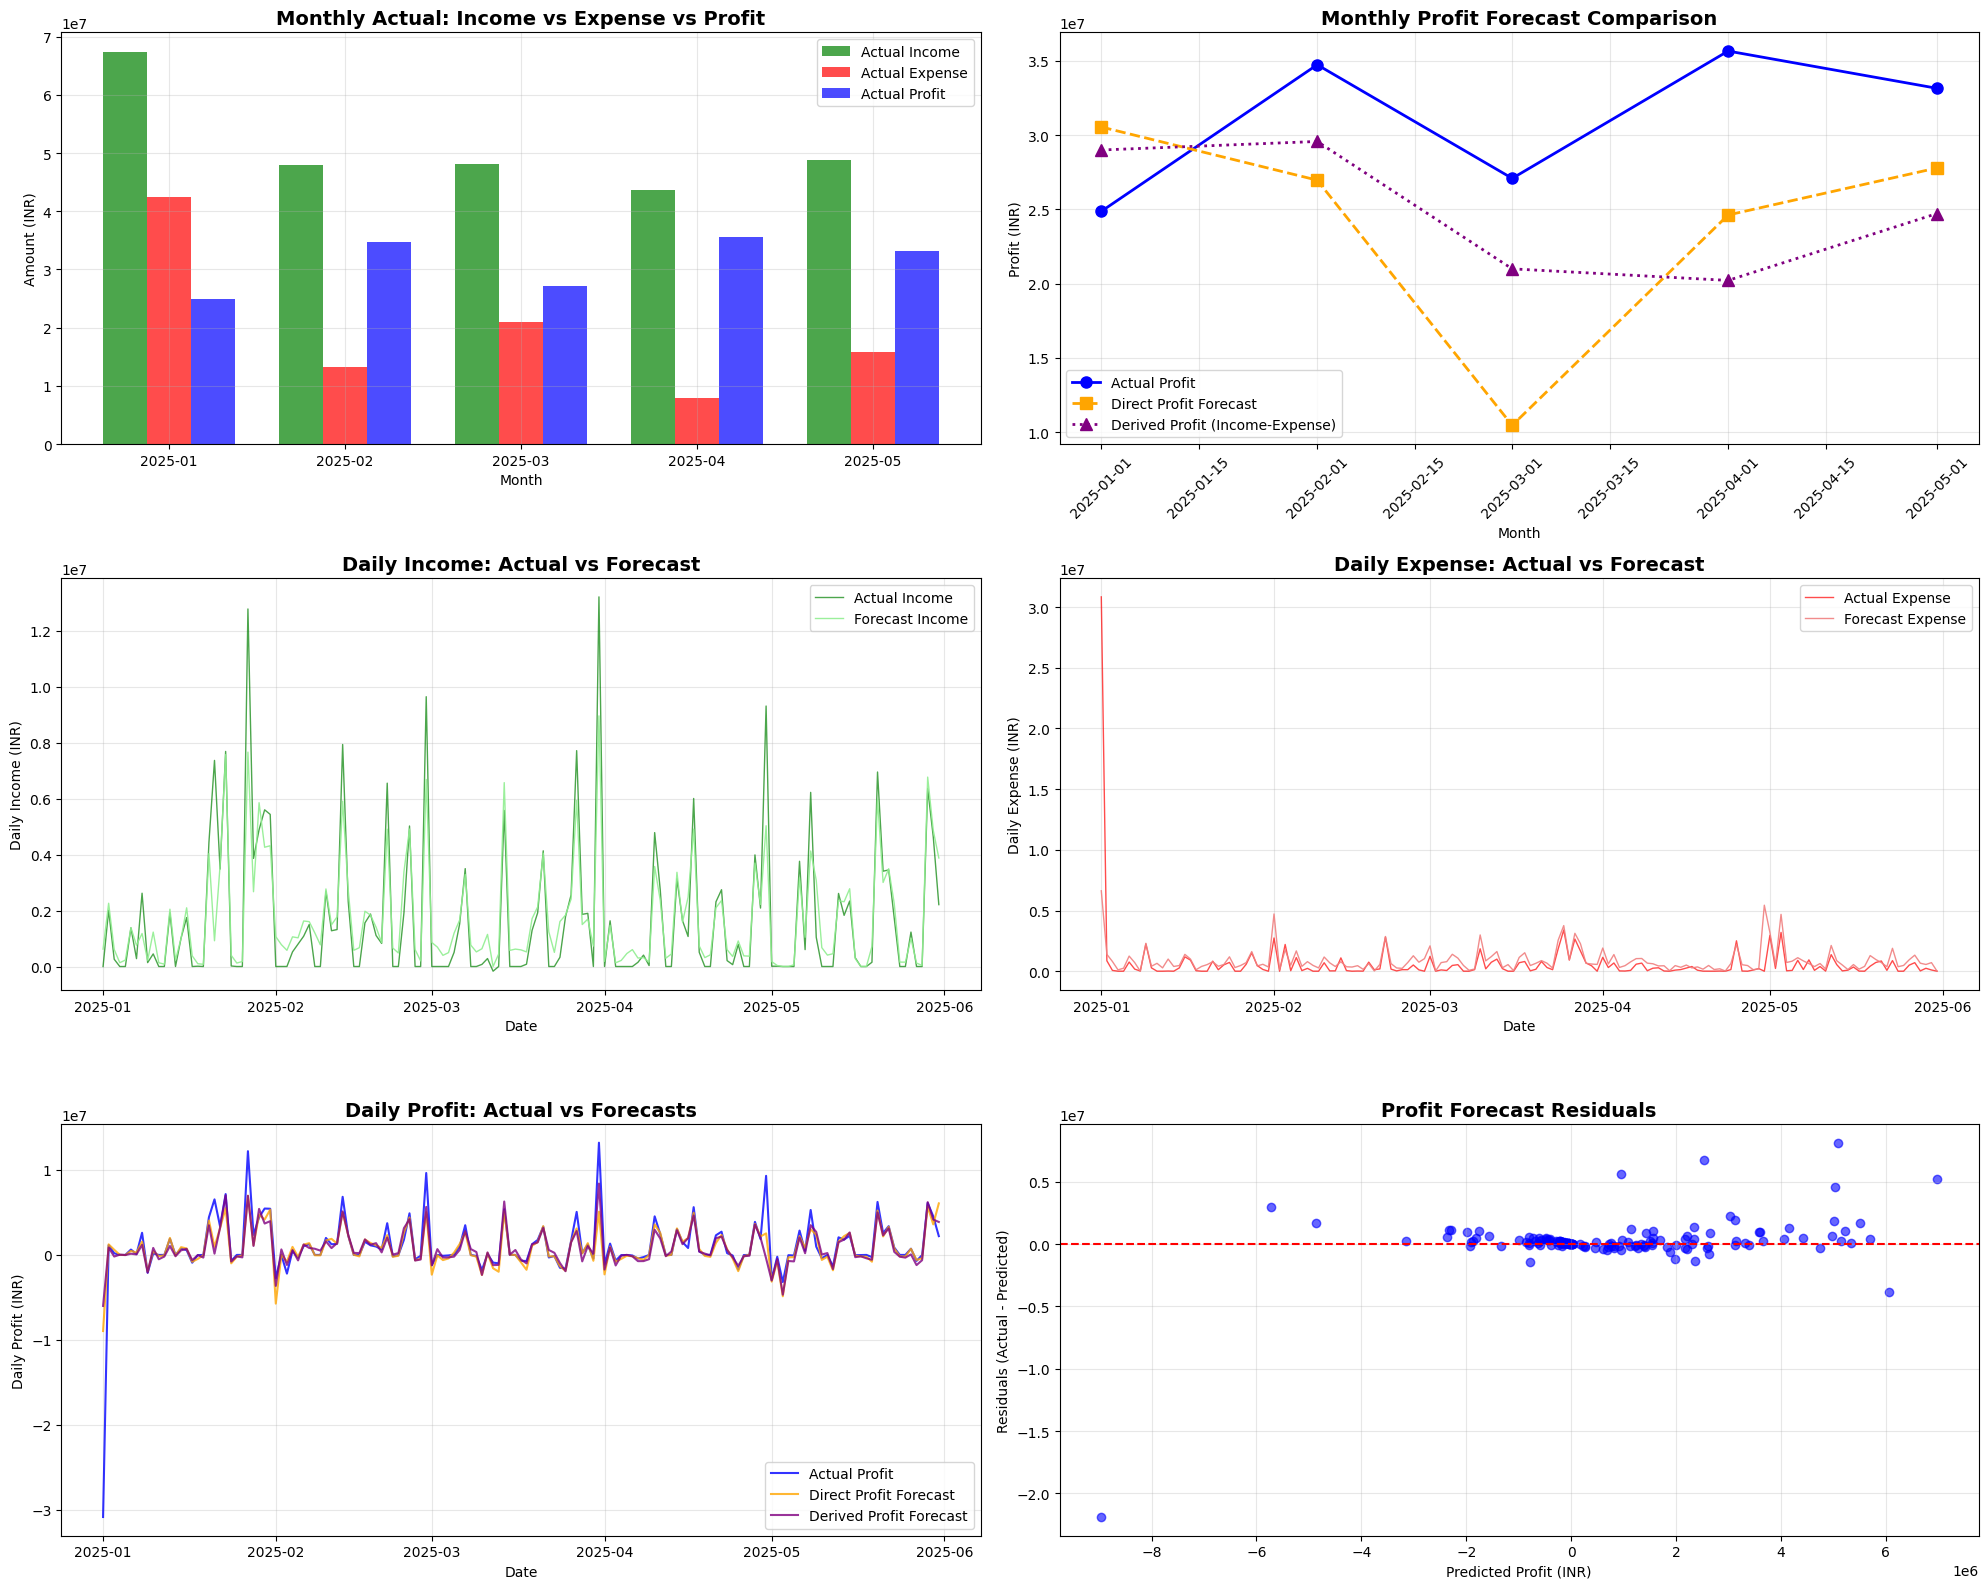


🔍 FEATURE IMPORTANCE ANALYSIS...

📈 Top 15 Most Important Features for Profit Prediction:
                        feature  importance
11                 is_month_end      0.4157
98                expense_ratio      0.1054
18            days_to_month_end      0.0720
85        profit_rolling_std_90      0.0720
91     historical_month_expense      0.0365
97                profit_margin      0.0294
87        profit_rolling_min_90      0.0205
109            days_since_start      0.0198
69       expense_rolling_std_90      0.0188
103            income_growth_7d      0.0124
22                 income_lag_7      0.0119
2                          year      0.0118
92   historical_quarter_expense      0.0101
70       expense_rolling_max_90      0.0091
53        income_rolling_std_90      0.0062


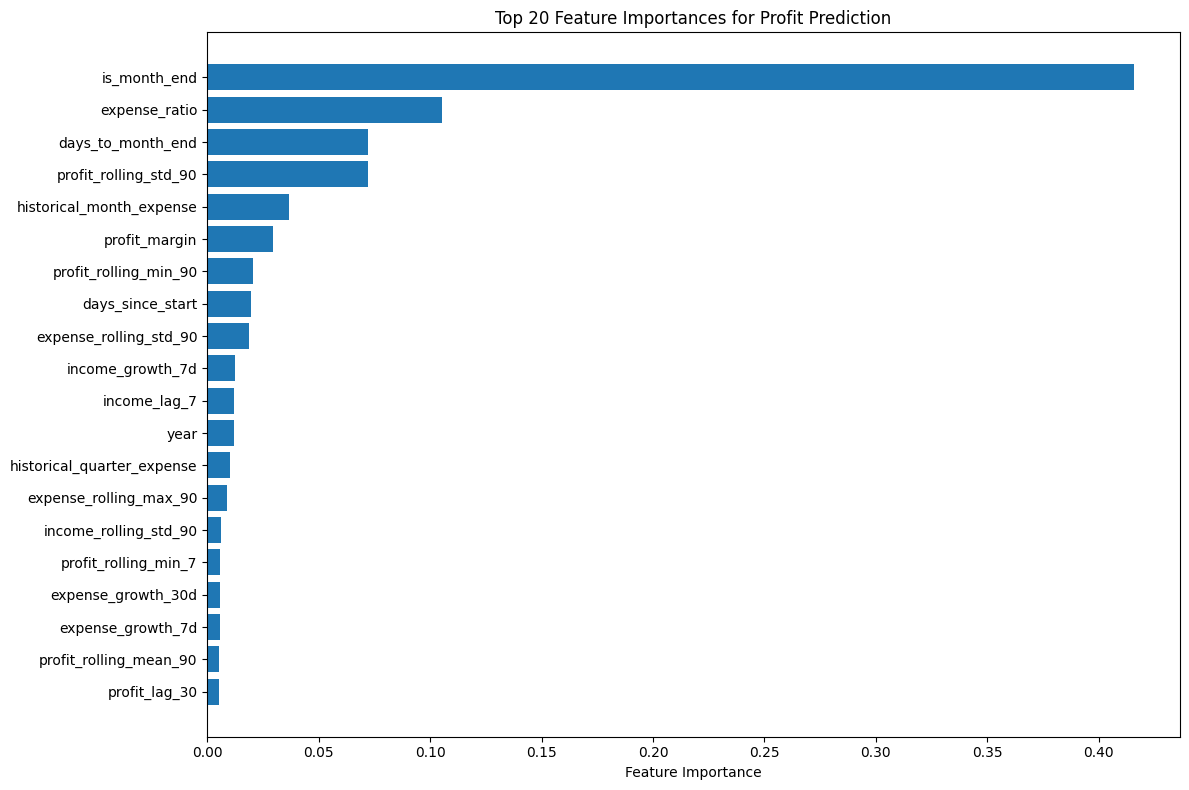


📅 DAILY PROFIT FORECAST SUMMARY
      Date  Actual_Income  Forecast_Income  Actual_Expense  Forecast_Expense  Actual_Profit  Direct_Profit_Forecast  Derived_Profit_Forecast  Profit_Error_%
2025-01-01           0.00     6.213113e+05     30844997.51      6.625091e+06   -30844997.51           -8.958456e+06            -6.003780e+06           70.96
2025-01-02     2008500.00     2.259788e+06       858834.65      1.390822e+06     1149665.35            1.243508e+06             8.689655e+05            8.16
2025-01-03      259600.00     6.079222e+05        62632.58      7.977314e+05      196967.42            6.059272e+05            -1.898092e+05          207.63
2025-01-04           0.00     1.355340e+05            0.00      1.083931e+05           0.00            8.853910e+03             2.714087e+04            0.00
2025-01-05           0.00     2.294922e+05            0.00      2.458639e+05           0.00           -1.677412e+04            -1.637169e+04            0.00
2025-01-06     1381058.40

In [ ]:
# COMBINED INCOME-EXPENSE PROFIT FORECASTING MODEL
# Predicts company profits using XGBoost on both income and expense data

# STEP 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 2: Load Data (MODIFIED TO HANDLE BOTH CSV AND EXCEL)
print("📂 LOADING DATA...")
file_path = "/content/Predictive_Analysis_Final.xlsx" # Original file path

df = pd.DataFrame() # Initialize an empty DataFrame

if file_path.lower().endswith('.csv'):
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded CSV file: {file_path}")
    except FileNotFoundError:
        print(f"Error: CSV file '{file_path}' not found. Please check the path.")
    except UnicodeDecodeError:
        print(f"Error: Could not decode CSV file '{file_path}' with default encoding. Trying 'latin1'.")
        try:
            df = pd.read_csv(file_path, encoding='latin1')
            print(f"Successfully loaded CSV file with 'latin1' encoding.")
        except Exception as e:
            print(f"Error loading CSV with 'latin1' encoding: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while loading CSV file: {e}")
elif file_path.lower().endswith('.xlsx') or file_path.lower().endswith('.xls'):
    try:
        # You need to install openpyxl: pip install openpyxl
        df = pd.read_excel(file_path, engine='openpyxl')
        print(f"Successfully loaded Excel file: {file_path}")
    except FileNotFoundError:
        print(f"Error: Excel file '{file_path}' not found. Please check the path.")
    except ImportError:
        print("Error: 'openpyxl' library not found. Please install it: pip install openpyxl")
    except Exception as e:
        print(f"An unexpected error occurred while loading Excel file: {e}")
else:
    print(f"Error: Unsupported file format for '{file_path}'. Please use .csv or .xlsx.")

if df.empty:
    print("❌ Dataframe is empty after loading. Exiting.")
    exit()

print(f"Original DataFrame shape: {df.shape}")
print(f"Original DataFrame columns: {df.columns.tolist()}")

# STEP 3: Process Income Data
print("\n🟢 PROCESSING INCOME DATA...")
income_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Income')].copy()
print(f"Income records: {income_df.shape[0]:,}")

if not income_df.empty:
    # Use errors='coerce' to turn unparseable dates into NaT
    income_df['Transaction Date'] = pd.to_datetime(income_df['Transaction Date'], errors='coerce')
    income_df.dropna(subset=['Transaction Date'], inplace=True)
    income_df['Credit - Debit'] = pd.to_numeric(income_df['Credit - Debit'], errors='coerce')
    income_df.dropna(subset=['Credit - Debit'], inplace=True)

    # Daily income aggregation
    daily_income = income_df.groupby('Transaction Date')['Credit - Debit'].sum().reset_index()
    daily_income.columns = ['ds', 'income']

    # Remove income outliers
    if len(daily_income) > 1 and daily_income['income'].std() > 0: # Check to avoid error on single-row/zero-std data
        mean_income = daily_income['income'].mean()
        std_income = daily_income['income'].std()
        daily_income = daily_income[np.abs(daily_income['income'] - mean_income) <= 3 * std_income].copy()
    else:
        print("Skipping income outlier removal due to insufficient data or zero standard deviation.")

    print(f"Daily income data points: {len(daily_income):,}")
    print(f"Average daily income: ₹{daily_income['income'].mean():,.2f}")
else:
    daily_income = pd.DataFrame(columns=['ds', 'income'])
    print("⚠️ No income data found!")

# STEP 4: Process Expense Data
print("\n🔴 PROCESSING EXPENSE DATA...")
expense_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Expense')].copy()
print(f"Expense records: {expense_df.shape[0]:,}")

if not expense_df.empty:
    expense_df['Transaction Date'] = pd.to_datetime(expense_df['Transaction Date'], errors='coerce')
    expense_df.dropna(subset=['Transaction Date'], inplace=True)
    expense_df['Debit - Credit'] = pd.to_numeric(expense_df['Debit - Credit'], errors='coerce')
    expense_df.dropna(subset=['Debit - Credit'], inplace=True)

    # For expenses, use absolute values
    expense_df['Expense Amount'] = expense_df['Debit - Credit'].abs()

    # Daily expense aggregation
    daily_expense = expense_df.groupby('Transaction Date')['Expense Amount'].sum().reset_index()
    daily_expense.columns = ['ds', 'expense']

    # Remove expense outliers
    if len(daily_expense) > 1 and daily_expense['expense'].std() > 0: # Check to avoid error on single-row/zero-std data
        mean_expense = daily_expense['expense'].mean()
        std_expense = daily_expense['expense'].std()
        daily_expense = daily_expense[np.abs(daily_expense['expense'] - mean_expense) <= 3 * std_expense].copy()
    else:
        print("Skipping expense outlier removal due to insufficient data or zero standard deviation.")

    print(f"Daily expense data points: {len(daily_expense):,}")
    print(f"Average daily expense: ₹{daily_expense['expense'].mean():,.2f}")
else:
    daily_expense = pd.DataFrame(columns=['ds', 'expense'])
    print("⚠️ No expense data found!")

# STEP 5: Combine Income and Expense Data
print("\n💰 COMBINING INCOME & EXPENSE DATA...")

# Create date range covering both datasets
if not daily_income.empty and not daily_expense.empty:
    start_date = min(daily_income['ds'].min(), daily_expense['ds'].min())
    end_date = max(daily_income['ds'].max(), daily_expense['ds'].max())
elif not daily_income.empty:
    start_date = daily_income['ds'].min()
    end_date = daily_income['ds'].max()
elif not daily_expense.empty:
    start_date = daily_expense['ds'].min()
    end_date = daily_expense['ds'].max()
else:
    print("❌ No data available for processing income or expense! Cannot combine.")
    exit()

# Create complete date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
daily_combined = pd.DataFrame({'ds': date_range})

# Merge income and expense data
daily_combined = daily_combined.merge(daily_income, on='ds', how='left')
daily_combined = daily_combined.merge(daily_expense, on='ds', how='left')

# Fill missing values with 0
daily_combined['income'] = daily_combined['income'].fillna(0)
daily_combined['expense'] = daily_combined['expense'].fillna(0)

# Calculate daily profit
daily_combined['profit'] = daily_combined['income'] - daily_combined['expense']

print(f"Combined dataset shape: {daily_combined.shape}")
print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Average daily profit: ₹{daily_combined['profit'].mean():,.2f}")
print(f"Total profit in period: ₹{daily_combined['profit'].sum():,.2f}")

# STEP 6: Enhanced Feature Engineering for Profit Prediction
def create_profit_features(df):
    df = df.copy()

    # Basic date features
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter

    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Business calendar features
    df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)
    df['is_fy_end'] = (df['month'] == 3).astype(int)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Days from important dates
    df['days_from_month_start'] = df['day'] - 1
    df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']

    # Lag features for all components
    for component in ['income', 'expense', 'profit']:
        for lag in [1, 2, 3, 7, 14, 30, 90]:
            df[f'{component}_lag_{lag}'] = df[component].shift(lag)

    # Rolling statistics for all components
    for component in ['income', 'expense', 'profit']:
        for window in [7, 14, 30, 90]:
            df[f'{component}_rolling_mean_{window}'] = df[component].rolling(window, min_periods=1).mean().shift(1)
            df[f'{component}_rolling_std_{window}'] = df[component].rolling(window, min_periods=1).std().shift(1)
            df[f'{component}_rolling_max_{window}'] = df[component].rolling(window, min_periods=1).max().shift(1)
            df[f'{component}_rolling_min_{window}'] = df[component].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    for component in ['income', 'expense', 'profit']:
        df[f'historical_month_{component}'] = df.groupby('month')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df[f'historical_quarter_{component}'] = df.groupby('quarter')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df[f'historical_dow_{component}'] = df.groupby('dayofweek')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )

    # Profit ratios and business metrics
    epsilon = 1e-6
    df['profit_margin'] = df['profit'] / (df['income'] + epsilon)
    df['expense_ratio'] = df['expense'] / (df['income'] + epsilon)

    # Volatility features
    df['profit_volatility_7d'] = df['profit'].rolling(7).std().shift(1)
    df['profit_volatility_30d'] = df['profit'].rolling(30).std().shift(1)
    df['income_volatility_7d'] = df['income'].rolling(7).std().shift(1)
    df['expense_volatility_7d'] = df['expense'].rolling(7).std().shift(1)

    # Growth rates
    for component in ['income', 'expense', 'profit']:
        df[f'{component}_growth_7d'] = ((df[component] / df[component].shift(7).replace(0, np.nan)) - 1) * 100
        df[f'{component}_growth_30d'] = ((df[component] / df[component].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days

    return df

# Apply feature engineering
print("\n🛠️ CREATING FEATURES...")
daily_features = create_profit_features(daily_combined)

# Handle inf and NaN values
daily_features.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_features.fillna(method='bfill', inplace=True)
daily_features.fillna(method='ffill', inplace=True)
daily_features.fillna(0, inplace=True)

print(f"Features created. Dataset shape: {daily_features.shape}")

# ---
## STEP 7: Split Train/Test Data (Adjusted for Jan-May 2025 Test Set)
print("\n📊 SPLITTING DATA...")
# Define the new test period
test_start_date = pd.to_datetime('2025-01-01')
test_end_date = pd.to_datetime('2025-05-31')

# The training set will be all data before the test_start_date
train = daily_features[daily_features['ds'] < test_start_date].copy()
# The test set will be data within the specified Jan-May 2025 range
test = daily_features[(daily_features['ds'] >= test_start_date) &
                      (daily_features['ds'] <= test_end_date)].copy()

# This fallback logic might still be useful if the 2025 data isn't present
# or if the date range doesn't cover Jan-May 2025
if test.empty:
    print("⚠️ No test data for Jan-May 2025 in the dataset. Using last 3 months as fallback test set.")
    if not daily_features.empty:
        # Determine the effective end date of the entire dataset
        effective_end_date = daily_features['ds'].max()
        # Calculate the start date for the last 3 months
        fallback_test_start_date = effective_end_date - pd.DateOffset(months=3)
        # Ensure fallback start date isn't before the earliest data point
        fallback_test_start_date = max(fallback_test_start_date, daily_features['ds'].min())

        train = daily_features[daily_features['ds'] < fallback_test_start_date].copy()
        test = daily_features[daily_features['ds'] >= fallback_test_start_date].copy()
    else:
        print("❌ No features data available for splitting. Exiting.")
        exit()

if train.empty or test.empty:
    print("❌ Training or Test dataset is empty after splitting. Cannot proceed with model training.")
    exit()

print(f"Training data: {train.shape[0]:,} days")
print(f"Test data: {test.shape[0]:,} days")
print(f"Test period: {test['ds'].min().strftime('%Y-%m-%d')} to {test['ds'].max().strftime('%Y-%m-%d')}")

# Select features (excluding target variables and date)
feature_cols = [col for col in daily_features.columns
                if col not in ['ds', 'income', 'expense', 'profit']]
print(f"Number of features: {len(feature_cols)}")

# STEP 8: Train Models for Income, Expense, and Profit
print("\n🚀 TRAINING MODELS...")

# Model configuration
model_config = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

# Train individual models
models = {}
for target in ['income', 'expense', 'profit']:
    print(f"Training {target} model...")
    # Ensure all feature columns exist in the training data
    missing_cols = [col for col in feature_cols if col not in train.columns]
    if missing_cols:
        print(f"Warning: Missing columns in train data for {target} model: {missing_cols}")
        # Consider dropping these features or handling them if they are genuinely missing
        # For now, we'll proceed with available features, which might lead to errors if critical features are missing
        # A more robust solution might require re-evaluating feature creation or data merging steps.

    models[target] = XGBRegressor(**model_config)
    models[target].fit(train[feature_cols], train[target])

# STEP 9: Make Predictions
print("\n🔮 MAKING PREDICTIONS...")
test_pred = test.copy()

for target in ['income', 'expense', 'profit']:
    test_pred[f'{target}_forecast'] = models[target].predict(test[feature_cols])
    # Ensure non-negative values for income and expense
    if target in ['income', 'expense']:
        test_pred[f'{target}_forecast'] = test_pred[f'{target}_forecast'].clip(lower=0)

# Calculate derived profit from income and expense predictions
test_pred['profit_derived'] = test_pred['income_forecast'] - test_pred['expense_forecast']

# STEP 10: Monthly Aggregation and Metrics
print("\n📈 CALCULATING METRICS...")

def calculate_metrics(actual, forecast, metric_name):
    monthly_actual = actual.groupby(actual.index.to_period('M')).sum()
    monthly_forecast = forecast.groupby(forecast.index.to_period('M')).sum()

    mae = mean_absolute_error(monthly_actual, monthly_forecast)
    rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))

    # Safe MAPE calculation
    mask = monthly_actual != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((monthly_actual[mask] - monthly_forecast[mask]) / monthly_actual[mask])) * 100
        accuracy = 100 - mape
    else:
        mape = 0
        accuracy = 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': accuracy,
        'Monthly_Actual': monthly_actual,
        'Monthly_Forecast': monthly_forecast
    }

# Calculate metrics for all targets
test_pred.set_index('ds', inplace=True)
metrics = {}

for target in ['income', 'expense', 'profit']:
    metrics[target] = calculate_metrics(
        test_pred[target],
        test_pred[f'{target}_forecast'],
        target
    )

# Also calculate metrics for derived profit
metrics['profit_derived'] = calculate_metrics(
    test_pred['profit'],
    test_pred['profit_derived'],
    'profit_derived'
)

# STEP 11: Display Results
print("\n" + "="*60)
print("📊 FORECAST ACCURACY RESULTS")
print("="*60)

for target, metric in metrics.items():
    print(f"\n🎯 {target.upper()} FORECAST:")
    print(f"    MAE: ₹{metric['MAE']:,.2f}")
    print(f"    RMSE: ₹{metric['RMSE']:,.2f}")
    print(f"    MAPE: {metric['MAPE']:.2f}%")
    print(f"    ✅ Accuracy: {metric['Accuracy']:.2f}%")

# STEP 12: Create Comprehensive Comparison Tables
print("\n" + "="*80)
print("📋 MONTHLY FORECAST COMPARISON")
print("="*80)

# Monthly comparison table
monthly_comparison = pd.DataFrame({
    'Actual_Income': metrics['income']['Monthly_Actual'],
    'Forecast_Income': metrics['income']['Monthly_Forecast'],
    'Actual_Expense': metrics['expense']['Monthly_Actual'],
    'Forecast_Expense': metrics['expense']['Monthly_Forecast'],
    'Actual_Profit': metrics['profit']['Monthly_Actual'],
    'Forecast_Profit': metrics['profit']['Monthly_Forecast'],
    'Derived_Profit': metrics['profit_derived']['Monthly_Forecast']
})

monthly_comparison['Profit_Error'] = monthly_comparison['Actual_Profit'] - monthly_comparison['Forecast_Profit']
monthly_comparison['Profit_Error_%'] = (monthly_comparison['Profit_Error'].abs() /
                                        monthly_comparison['Actual_Profit'].abs()) * 100

print(monthly_comparison.round(2))

# STEP 13: Comprehensive Visualizations
print("\n🎨 CREATING VISUALIZATIONS...")

# Create comprehensive plots
fig = plt.figure(figsize=(20, 16))

# 1. Monthly Overview
ax1 = plt.subplot(3, 2, 1)
x = range(len(monthly_comparison))
width = 0.25

plt.bar([i - width for i in x], monthly_comparison['Actual_Income'], width,
        label='Actual Income', color='green', alpha=0.7)
plt.bar(x, monthly_comparison['Actual_Expense'], width,
        label='Actual Expense', color='red', alpha=0.7)
plt.bar([i + width for i in x], monthly_comparison['Actual_Profit'], width,
        label='Actual Profit', color='blue', alpha=0.7)

plt.title('Monthly Actual: Income vs Expense vs Profit', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Amount (INR)')
plt.xticks(x, [str(idx)[:7] for idx in monthly_comparison.index])
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Profit Forecast Comparison
ax2 = plt.subplot(3, 2, 2)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Actual_Profit'],
         'o-', label='Actual Profit', color='blue', linewidth=2, markersize=8)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Forecast_Profit'],
         's--', label='Direct Profit Forecast', color='orange', linewidth=2, markersize=8)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Derived_Profit'],
         '^:', label='Derived Profit (Income-Expense)', color='purple', linewidth=2, markersize=8)

plt.title('Monthly Profit Forecast Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Profit (INR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 3. Daily Income Forecast
ax3 = plt.subplot(3, 2, 3)
plt.plot(test_pred.index, test_pred['income'], label='Actual Income',
         color='green', alpha=0.7, linewidth=1)
plt.plot(test_pred.index, test_pred['income_forecast'], label='Forecast Income',
         color='lightgreen', alpha=0.9, linewidth=1)
plt.title('Daily Income: Actual vs Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Income (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Daily Expense Forecast
ax4 = plt.subplot(3, 2, 4)
plt.plot(test_pred.index, test_pred['expense'], label='Actual Expense',
         color='red', alpha=0.7, linewidth=1)
plt.plot(test_pred.index, test_pred['expense_forecast'], label='Forecast Expense',
         color='lightcoral', alpha=0.9, linewidth=1)
plt.title('Daily Expense: Actual vs Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Expense (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Daily Profit Forecast
ax5 = plt.subplot(3, 2, 5)
plt.plot(test_pred.index, test_pred['profit'], label='Actual Profit',
         color='blue', alpha=0.8, linewidth=1.5)
plt.plot(test_pred.index, test_pred['profit_forecast'], label='Direct Profit Forecast',
         color='orange', alpha=0.8, linewidth=1.5)
plt.plot(test_pred.index, test_pred['profit_derived'], label='Derived Profit Forecast',
         color='purple', alpha=0.8, linewidth=1.5)
plt.title('Daily Profit: Actual vs Forecasts', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Profit (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Profit Forecast Accuracy
ax6 = plt.subplot(3, 2, 6)
profit_residuals = test_pred['profit'] - test_pred['profit_forecast']
plt.scatter(test_pred['profit_forecast'], profit_residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Profit Forecast Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Profit (INR)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 14: Feature Importance Analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS...")

# Get feature importance for profit model
profit_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': models['profit'].feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📈 Top 15 Most Important Features for Profit Prediction:")
print(profit_importance.head(15).round(4))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = profit_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances for Profit Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 15: Daily Forecast Summary Table
print("\n" + "="*100)
print("📅 DAILY PROFIT FORECAST SUMMARY")
print("="*100)

daily_summary = test_pred[['income', 'income_forecast', 'expense', 'expense_forecast',
                           'profit', 'profit_forecast', 'profit_derived']].copy()
daily_summary.reset_index(inplace=True)
daily_summary['Profit_Error_%'] = np.where(
    daily_summary['profit'] == 0, 0,
    ((daily_summary['profit_forecast'] - daily_summary['profit']) / daily_summary['profit'].abs()) * 100
)

# Rename columns for better readability
daily_summary.columns = [
    'Date', 'Actual_Income', 'Forecast_Income', 'Actual_Expense', 'Forecast_Expense',
    'Actual_Profit', 'Direct_Profit_Forecast', 'Derived_Profit_Forecast', 'Profit_Error_%'
]

# Round values
daily_summary = daily_summary.round({
    'Actual_Income': 2, 'Forecast_Income': 2, 'Actual_Expense': 2, 'Forecast_Expense': 2,
    'Actual_Profit': 2, 'Direct_Profit_Forecast': 2, 'Derived_Profit_Forecast': 2, 'Profit_Error_%': 2
})

print(daily_summary.to_string(index=False))

print("\n" + "="*60)
print("🎊 PROFIT FORECASTING ANALYSIS COMPLETE!")
print("="*60)
print(f"✅ Best Profit Forecast Accuracy: {max(metrics['profit']['Accuracy'], metrics['profit_derived']['Accuracy']):.2f}%")
print(f"📊 Total Test Period Profit: ₹{test_pred['profit'].sum():,.2f}")
print(f"🔮 Total Forecasted Profit: ₹{test_pred['profit_forecast'].sum():,.2f}")
print(f"💰 Forecast vs Actual Difference: ₹{(test_pred['profit_forecast'].sum() - test_pred['profit'].sum()):,.2f}")

📂 LOADING DATA...
Successfully loaded CSV file: /content/loadshare_predictive_analytics.csv
Original DataFrame shape: (683302, 10)
Original DataFrame columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

🟢 PROCESSING INCOME DATA...
Income records: 26,860
Daily income data points: 251
Average daily income: ₹11,481,198.68

🔴 PROCESSING EXPENSE DATA...
Expense records: 75,955
Daily expense data points: 1,189
Average daily expense: ₹3,960,269.82

💰 COMBINING INCOME & EXPENSE DATA...
Combined dataset shape: (2650, 4)
Date range: 2018-12-31 to 2026-04-02
Average daily profit: ₹-689,426.39
Total profit in period: ₹-1,826,979,941.43

🛠️ CREATING FEATURES...
Features created. Dataset shape: (2650, 114)

📊 SPLITTING DATA...
Training data: 2,252 days
Test data: 92 days
Test period: 2025-03-01 to 2025-05-31
Number of features: 110

🚀 TRAINING MODELS...
Training in

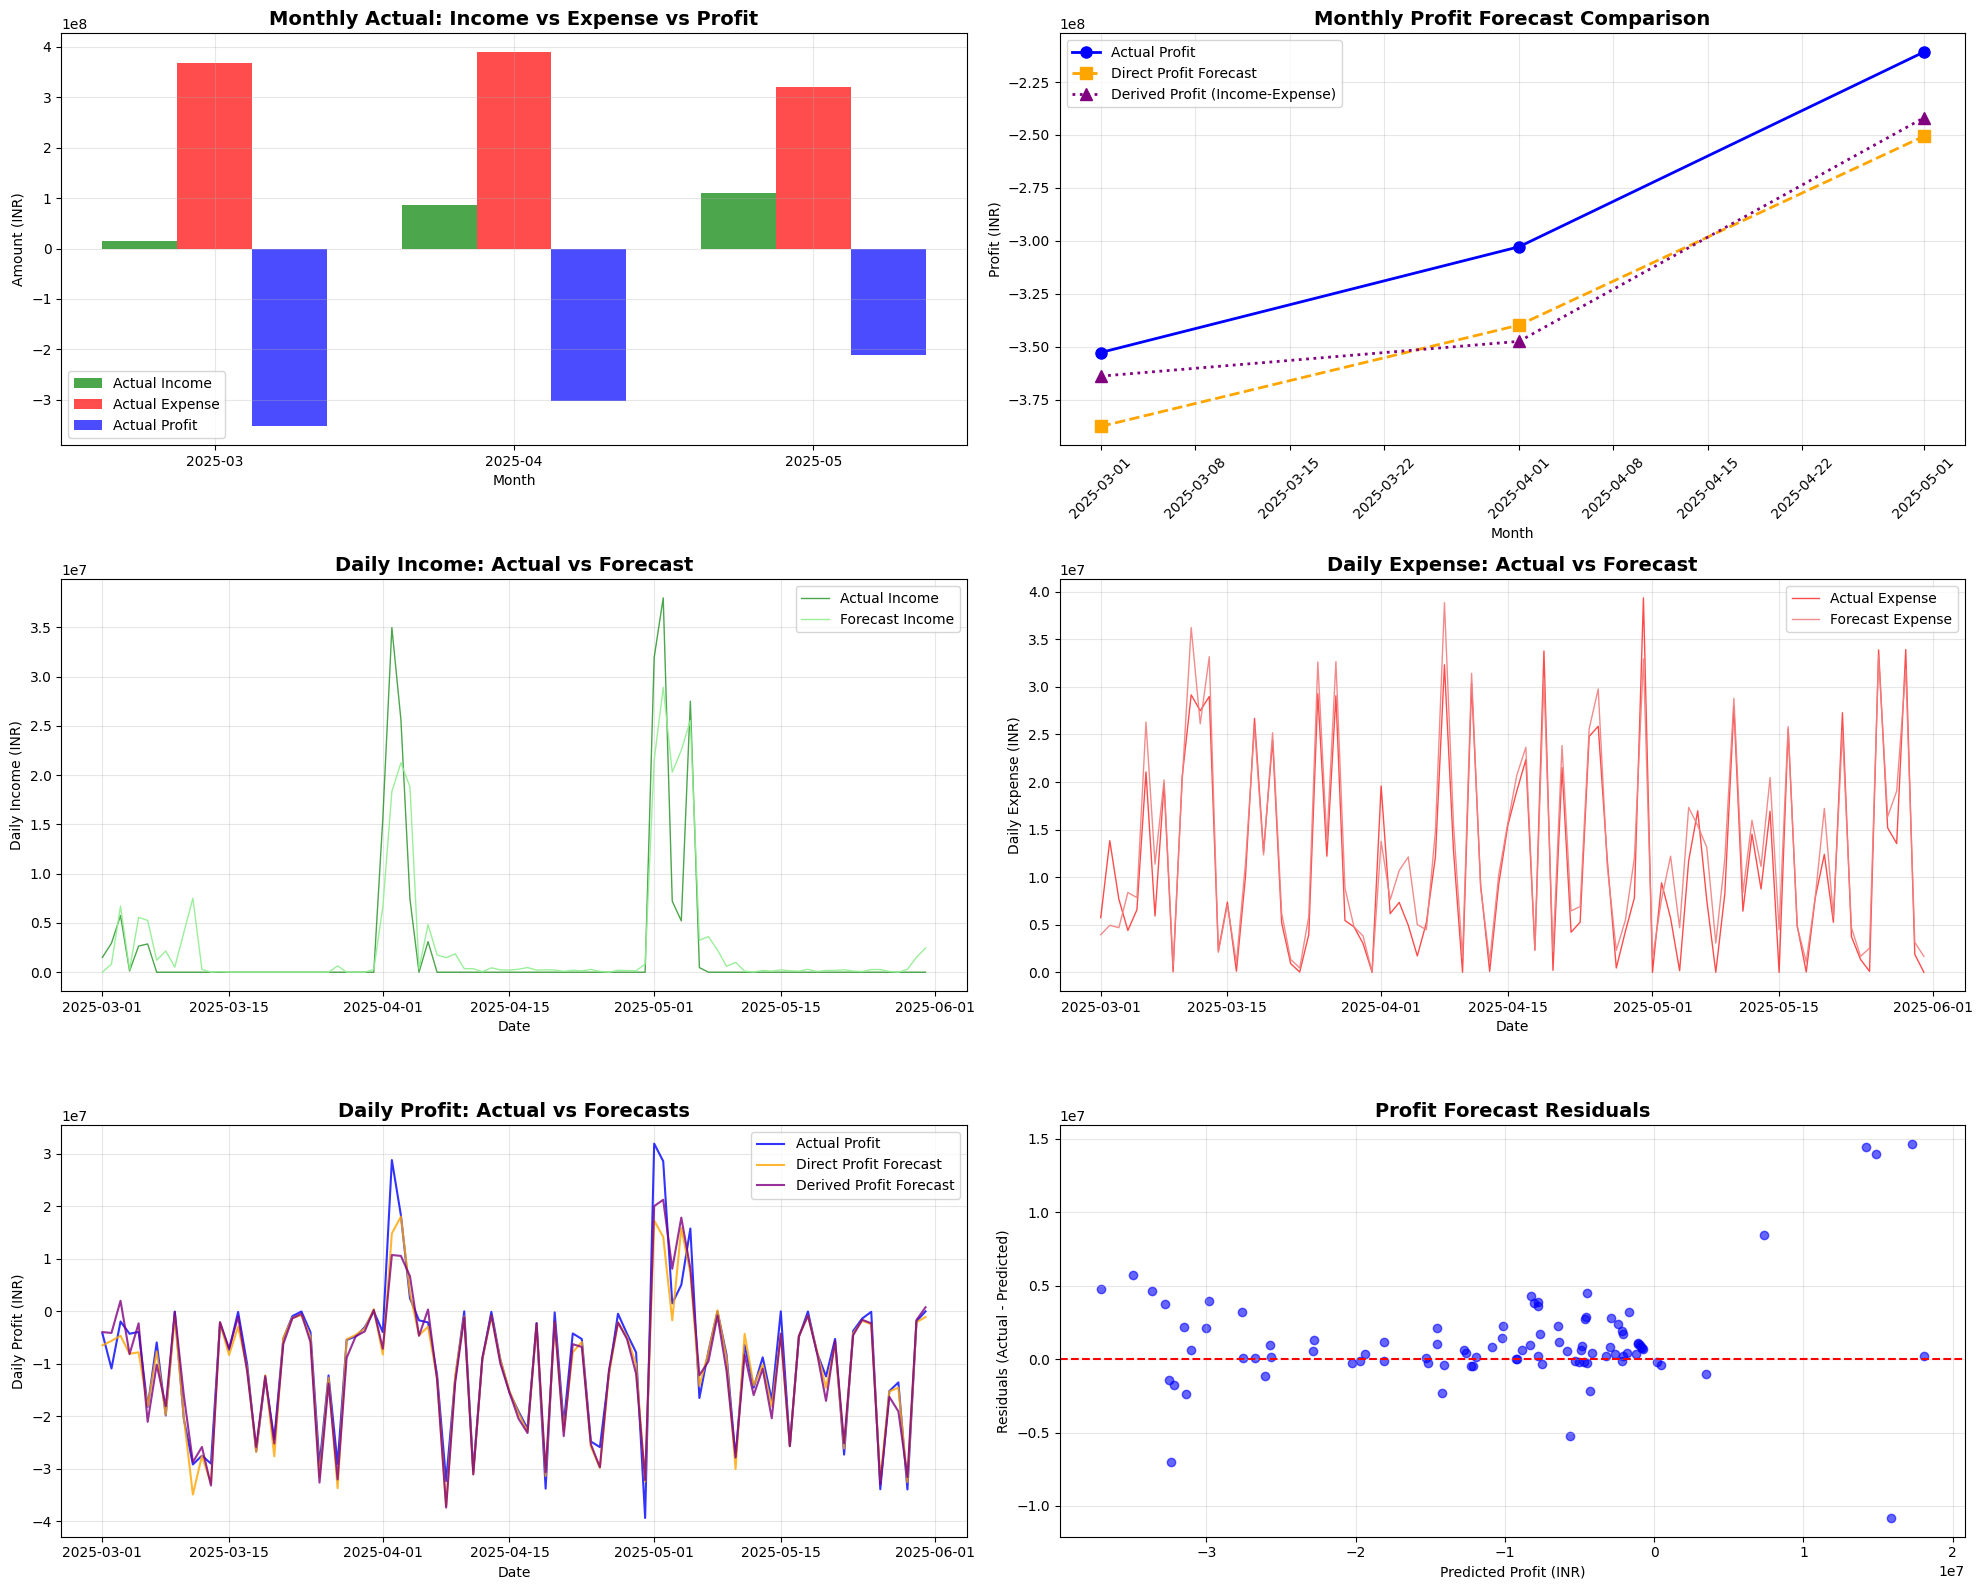


🔍 FEATURE IMPORTANCE ANALYSIS...

📈 Top 15 Most Important Features for Profit Prediction:
                        feature  importance
50        income_rolling_max_30      0.0949
98                expense_ratio      0.0819
97                profit_margin      0.0735
89    historical_quarter_income      0.0507
93       historical_dow_expense      0.0433
49        income_rolling_std_30      0.0431
82        profit_rolling_max_30      0.0344
54        income_rolling_max_90      0.0277
36                 profit_lag_7      0.0259
107            profit_growth_7d      0.0250
92   historical_quarter_expense      0.0233
22                 income_lag_7      0.0230
44       income_rolling_mean_14      0.0177
99         profit_volatility_7d      0.0167
37                profit_lag_14      0.0151


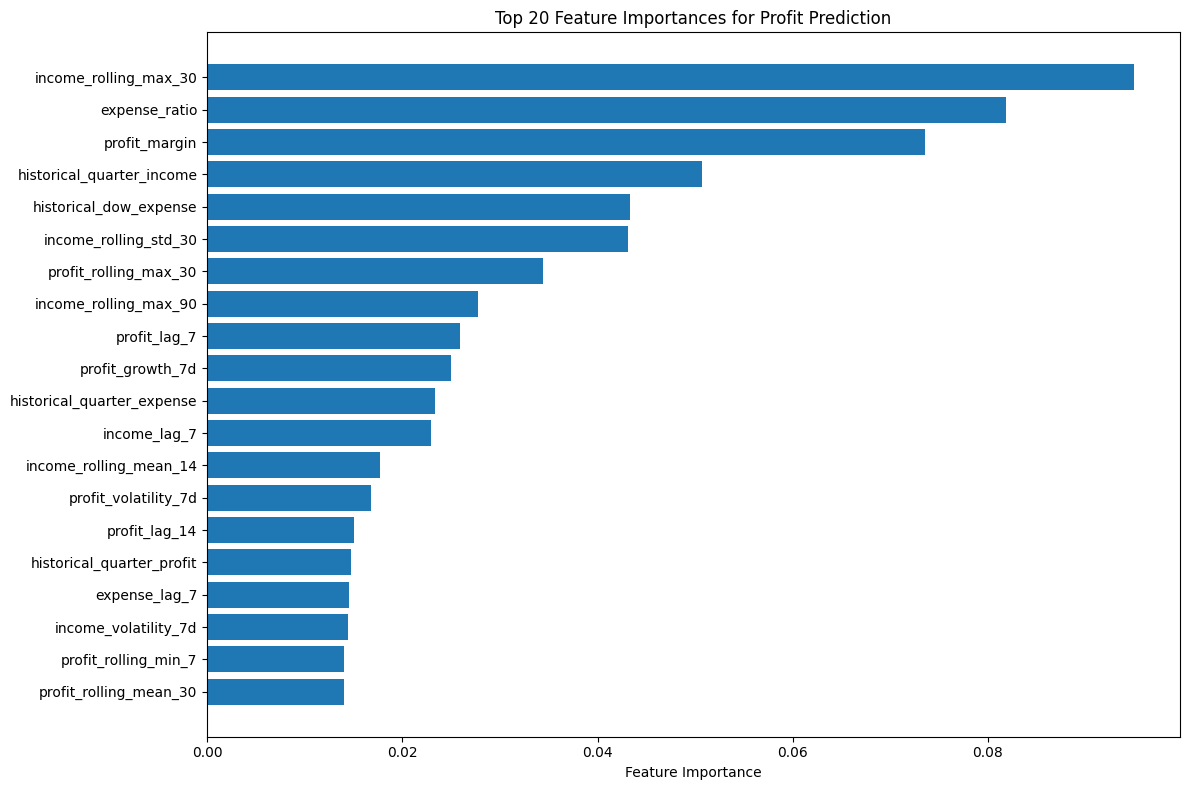


📅 DAILY PROFIT FORECAST SUMMARY
      Date  Actual_Income  Forecast_Income  Actual_Expense  Forecast_Expense  Actual_Profit  Direct_Profit_Forecast  Derived_Profit_Forecast  Profit_Error_%
2025-03-01     1507933.21     0.000000e+00      5733841.77      3.942679e+06    -4225908.56           -6.469501e+06            -3.942679e+06          -53.09
2025-03-02     2947586.61     8.344386e+05     13831793.41      4.939700e+06   -10884206.80           -5.618772e+06            -4.105262e+06           48.38
2025-03-03     5757888.33     6.704390e+06      7686245.67      4.680020e+06    -1928357.34           -4.637582e+06             2.024370e+06         -140.49
2025-03-04      125325.51     2.475893e+05      4392389.62      8.384388e+06    -4267064.11           -8.079738e+06            -8.136798e+06          -89.35
2025-03-05     2653998.48     5.564906e+06      6563382.16      7.840822e+06    -3909383.68           -7.795882e+06            -2.275916e+06          -99.41
2025-03-06     2869366.11

In [ ]:
# COMBINED INCOME-EXPENSE PROFIT FORECASTING MODEL
# Predicts company profits using XGBoost on both income and expense data

# STEP 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 2: Load Data (MODIFIED TO HANDLE BOTH CSV AND EXCEL)
print("📂 LOADING DATA...")
file_path = "/content/loadshare_predictive_analytics.csv" # Original file path
# If you also want to test with the Excel file mentioned in the previous error:
# file_path_excel = "/content/Predictive_Analysis_Final.xlsx"

df = pd.DataFrame() # Initialize an empty DataFrame

if file_path.lower().endswith('.csv'):
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded CSV file: {file_path}")
    except FileNotFoundError:
        print(f"Error: CSV file '{file_path}' not found. Please check the path.")
    except UnicodeDecodeError:
        print(f"Error: Could not decode CSV file '{file_path}' with default encoding. Trying 'latin1'.")
        try:
            df = pd.read_csv(file_path, encoding='latin1')
            print(f"Successfully loaded CSV file with 'latin1' encoding.")
        except Exception as e:
            print(f"Error loading CSV with 'latin1' encoding: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while loading CSV file: {e}")
elif file_path.lower().endswith('.xlsx') or file_path.lower().endswith('.xls'):
    try:
        # You need to install openpyxl: pip install openpyxl
        df = pd.read_excel(file_path, engine='openpyxl')
        print(f"Successfully loaded Excel file: {file_path}")
    except FileNotFoundError:
        print(f"Error: Excel file '{file_path}' not found. Please check the path.")
    except ImportError:
        print("Error: 'openpyxl' library not found. Please install it: pip install openpyxl")
    except Exception as e:
        print(f"An unexpected error occurred while loading Excel file: {e}")
else:
    print(f"Error: Unsupported file format for '{file_path}'. Please use .csv or .xlsx.")

if df.empty:
    print("❌ Dataframe is empty after loading. Exiting.")
    exit()

print(f"Original DataFrame shape: {df.shape}")
print(f"Original DataFrame columns: {df.columns.tolist()}")

# STEP 3: Process Income Data
print("\n🟢 PROCESSING INCOME DATA...")
income_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Income')].copy()
print(f"Income records: {income_df.shape[0]:,}")

if not income_df.empty:
    # Use errors='coerce' to turn unparseable dates into NaT
    income_df['Transaction Date'] = pd.to_datetime(income_df['Transaction Date'], errors='coerce')
    income_df.dropna(subset=['Transaction Date'], inplace=True)
    income_df['Credit - Debit'] = pd.to_numeric(income_df['Credit - Debit'], errors='coerce')
    income_df.dropna(subset=['Credit - Debit'], inplace=True)

    # Daily income aggregation
    daily_income = income_df.groupby('Transaction Date')['Credit - Debit'].sum().reset_index()
    daily_income.columns = ['ds', 'income']

    # Remove income outliers
    if len(daily_income) > 1 and daily_income['income'].std() > 0: # Check to avoid error on single-row/zero-std data
        mean_income = daily_income['income'].mean()
        std_income = daily_income['income'].std()
        daily_income = daily_income[np.abs(daily_income['income'] - mean_income) <= 3 * std_income].copy()
    else:
        print("Skipping income outlier removal due to insufficient data or zero standard deviation.")

    print(f"Daily income data points: {len(daily_income):,}")
    print(f"Average daily income: ₹{daily_income['income'].mean():,.2f}")
else:
    daily_income = pd.DataFrame(columns=['ds', 'income'])
    print("⚠️ No income data found!")

# STEP 4: Process Expense Data
print("\n🔴 PROCESSING EXPENSE DATA...")
expense_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Expense')].copy()
print(f"Expense records: {expense_df.shape[0]:,}")

if not expense_df.empty:
    expense_df['Transaction Date'] = pd.to_datetime(expense_df['Transaction Date'], errors='coerce')
    expense_df.dropna(subset=['Transaction Date'], inplace=True)
    expense_df['Debit - Credit'] = pd.to_numeric(expense_df['Debit - Credit'], errors='coerce')
    expense_df.dropna(subset=['Debit - Credit'], inplace=True)

    # For expenses, use absolute values
    expense_df['Expense Amount'] = expense_df['Debit - Credit'].abs()

    # Daily expense aggregation
    daily_expense = expense_df.groupby('Transaction Date')['Expense Amount'].sum().reset_index()
    daily_expense.columns = ['ds', 'expense']

    # Remove expense outliers
    if len(daily_expense) > 1 and daily_expense['expense'].std() > 0: # Check to avoid error on single-row/zero-std data
        mean_expense = daily_expense['expense'].mean()
        std_expense = daily_expense['expense'].std()
        daily_expense = daily_expense[np.abs(daily_expense['expense'] - mean_expense) <= 3 * std_expense].copy()
    else:
        print("Skipping expense outlier removal due to insufficient data or zero standard deviation.")

    print(f"Daily expense data points: {len(daily_expense):,}")
    print(f"Average daily expense: ₹{daily_expense['expense'].mean():,.2f}")
else:
    daily_expense = pd.DataFrame(columns=['ds', 'expense'])
    print("⚠️ No expense data found!")

# STEP 5: Combine Income and Expense Data
print("\n💰 COMBINING INCOME & EXPENSE DATA...")

# Create date range covering both datasets
if not daily_income.empty and not daily_expense.empty:
    start_date = min(daily_income['ds'].min(), daily_expense['ds'].min())
    end_date = max(daily_income['ds'].max(), daily_expense['ds'].max())
elif not daily_income.empty:
    start_date = daily_income['ds'].min()
    end_date = daily_income['ds'].max()
elif not daily_expense.empty:
    start_date = daily_expense['ds'].min()
    end_date = daily_expense['ds'].max()
else:
    print("❌ No data available for processing income or expense! Cannot combine.")
    exit()

# Create complete date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
daily_combined = pd.DataFrame({'ds': date_range})

# Merge income and expense data
daily_combined = daily_combined.merge(daily_income, on='ds', how='left')
daily_combined = daily_combined.merge(daily_expense, on='ds', how='left')

# Fill missing values with 0
daily_combined['income'] = daily_combined['income'].fillna(0)
daily_combined['expense'] = daily_combined['expense'].fillna(0)

# Calculate daily profit
daily_combined['profit'] = daily_combined['income'] - daily_combined['expense']

print(f"Combined dataset shape: {daily_combined.shape}")
print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Average daily profit: ₹{daily_combined['profit'].mean():,.2f}")
print(f"Total profit in period: ₹{daily_combined['profit'].sum():,.2f}")

# STEP 6: Enhanced Feature Engineering for Profit Prediction
def create_profit_features(df):
    df = df.copy()

    # Basic date features
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter

    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Business calendar features
    df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)
    df['is_fy_end'] = (df['month'] == 3).astype(int)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Days from important dates
    df['days_from_month_start'] = df['day'] - 1
    df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']

    # Lag features for all components
    for component in ['income', 'expense', 'profit']:
        for lag in [1, 2, 3, 7, 14, 30, 90]:
            df[f'{component}_lag_{lag}'] = df[component].shift(lag)

    # Rolling statistics for all components
    for component in ['income', 'expense', 'profit']:
        for window in [7, 14, 30, 90]:
            df[f'{component}_rolling_mean_{window}'] = df[component].rolling(window, min_periods=1).mean().shift(1)
            df[f'{component}_rolling_std_{window}'] = df[component].rolling(window, min_periods=1).std().shift(1)
            df[f'{component}_rolling_max_{window}'] = df[component].rolling(window, min_periods=1).max().shift(1)
            df[f'{component}_rolling_min_{window}'] = df[component].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    for component in ['income', 'expense', 'profit']:
        df[f'historical_month_{component}'] = df.groupby('month')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df[f'historical_quarter_{component}'] = df.groupby('quarter')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df[f'historical_dow_{component}'] = df.groupby('dayofweek')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )

    # Profit ratios and business metrics
    epsilon = 1e-6
    df['profit_margin'] = df['profit'] / (df['income'] + epsilon)
    df['expense_ratio'] = df['expense'] / (df['income'] + epsilon)

    # Volatility features
    df['profit_volatility_7d'] = df['profit'].rolling(7).std().shift(1)
    df['profit_volatility_30d'] = df['profit'].rolling(30).std().shift(1)
    df['income_volatility_7d'] = df['income'].rolling(7).std().shift(1)
    df['expense_volatility_7d'] = df['expense'].rolling(7).std().shift(1)

    # Growth rates
    for component in ['income', 'expense', 'profit']:
        df[f'{component}_growth_7d'] = ((df[component] / df[component].shift(7).replace(0, np.nan)) - 1) * 100
        df[f'{component}_growth_30d'] = ((df[component] / df[component].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days

    return df

# Apply feature engineering
print("\n🛠️ CREATING FEATURES...")
daily_features = create_profit_features(daily_combined)

# Handle inf and NaN values
daily_features.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_features.fillna(method='bfill', inplace=True)
daily_features.fillna(method='ffill', inplace=True)
daily_features.fillna(0, inplace=True)

print(f"Features created. Dataset shape: {daily_features.shape}")

# STEP 7: Split Train/Test Data
print("\n📊 SPLITTING DATA...")
test_start_date = pd.to_datetime('2025-03-01')
test_end_date = pd.to_datetime('2025-05-31')

train = daily_features[daily_features['ds'] < test_start_date].copy()
test = daily_features[(daily_features['ds'] >= test_start_date) &
                      (daily_features['ds'] <= test_end_date)].copy()

# If no test data in 2025, use last 3 months
if test.empty:
    print("⚠️ No test data for Mar-May 2025, using last 3 months as test set")
    if not daily_features.empty:
        test_start_date = daily_features['ds'].max() - pd.DateOffset(months=3)
        train = daily_features[daily_features['ds'] < test_start_date].copy()
        test = daily_features[daily_features['ds'] >= test_start_date].copy()
    else:
        print("❌ No features data available for splitting. Exiting.")
        exit()

if train.empty or test.empty:
    print("❌ Training or Test dataset is empty after splitting. Cannot proceed with model training.")
    exit()

print(f"Training data: {train.shape[0]:,} days")
print(f"Test data: {test.shape[0]:,} days")
print(f"Test period: {test['ds'].min().strftime('%Y-%m-%d')} to {test['ds'].max().strftime('%Y-%m-%d')}")

# Select features (excluding target variables and date)
feature_cols = [col for col in daily_features.columns
                if col not in ['ds', 'income', 'expense', 'profit']]
print(f"Number of features: {len(feature_cols)}")

# STEP 8: Train Models for Income, Expense, and Profit
print("\n🚀 TRAINING MODELS...")

# Model configuration
model_config = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

# Train individual models
models = {}
for target in ['income', 'expense', 'profit']:
    print(f"Training {target} model...")
    # Ensure all feature columns exist in the training data
    missing_cols = [col for col in feature_cols if col not in train.columns]
    if missing_cols:
        print(f"Warning: Missing columns in train data for {target} model: {missing_cols}")
        # Consider dropping these features or handling them if they are genuinely missing
        # For now, we'll proceed with available features, which might lead to errors if critical features are missing
        # A more robust solution might require re-evaluating feature creation or data merging steps.

    models[target] = XGBRegressor(**model_config)
    models[target].fit(train[feature_cols], train[target])

# STEP 9: Make Predictions
print("\n🔮 MAKING PREDICTIONS...")
test_pred = test.copy()

for target in ['income', 'expense', 'profit']:
    test_pred[f'{target}_forecast'] = models[target].predict(test[feature_cols])
    # Ensure non-negative values for income and expense
    if target in ['income', 'expense']:
        test_pred[f'{target}_forecast'] = test_pred[f'{target}_forecast'].clip(lower=0)

# Calculate derived profit from income and expense predictions
test_pred['profit_derived'] = test_pred['income_forecast'] - test_pred['expense_forecast']

# STEP 10: Monthly Aggregation and Metrics
print("\n📈 CALCULATING METRICS...")

def calculate_metrics(actual, forecast, metric_name):
    monthly_actual = actual.groupby(actual.index.to_period('M')).sum()
    monthly_forecast = forecast.groupby(forecast.index.to_period('M')).sum()

    mae = mean_absolute_error(monthly_actual, monthly_forecast)
    rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))

    # Safe MAPE calculation
    mask = monthly_actual != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((monthly_actual[mask] - monthly_forecast[mask]) / monthly_actual[mask])) * 100
        accuracy = 100 - mape
    else:
        mape = 0
        accuracy = 100

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': accuracy,
        'Monthly_Actual': monthly_actual,
        'Monthly_Forecast': monthly_forecast
    }

# Calculate metrics for all targets
test_pred.set_index('ds', inplace=True)
metrics = {}

for target in ['income', 'expense', 'profit']:
    metrics[target] = calculate_metrics(
        test_pred[target],
        test_pred[f'{target}_forecast'],
        target
    )

# Also calculate metrics for derived profit
metrics['profit_derived'] = calculate_metrics(
    test_pred['profit'],
    test_pred['profit_derived'],
    'profit_derived'
)

# STEP 11: Display Results
print("\n" + "="*60)
print("📊 FORECAST ACCURACY RESULTS")
print("="*60)

for target, metric in metrics.items():
    print(f"\n🎯 {target.upper()} FORECAST:")
    print(f"    MAE: ₹{metric['MAE']:,.2f}")
    print(f"    RMSE: ₹{metric['RMSE']:,.2f}")
    print(f"    MAPE: {metric['MAPE']:.2f}%")
    print(f"    ✅ Accuracy: {metric['Accuracy']:.2f}%")

# STEP 12: Create Comprehensive Comparison Tables
print("\n" + "="*80)
print("📋 MONTHLY FORECAST COMPARISON")
print("="*80)

# Monthly comparison table
monthly_comparison = pd.DataFrame({
    'Actual_Income': metrics['income']['Monthly_Actual'],
    'Forecast_Income': metrics['income']['Monthly_Forecast'],
    'Actual_Expense': metrics['expense']['Monthly_Actual'],
    'Forecast_Expense': metrics['expense']['Monthly_Forecast'],
    'Actual_Profit': metrics['profit']['Monthly_Actual'],
    'Forecast_Profit': metrics['profit']['Monthly_Forecast'],
    'Derived_Profit': metrics['profit_derived']['Monthly_Forecast']
})

monthly_comparison['Profit_Error'] = monthly_comparison['Actual_Profit'] - monthly_comparison['Forecast_Profit']
monthly_comparison['Profit_Error_%'] = (monthly_comparison['Profit_Error'].abs() /
                                        monthly_comparison['Actual_Profit'].abs()) * 100

print(monthly_comparison.round(2))

# STEP 13: Comprehensive Visualizations
print("\n🎨 CREATING VISUALIZATIONS...")

# Create comprehensive plots
fig = plt.figure(figsize=(20, 16))

# 1. Monthly Overview
ax1 = plt.subplot(3, 2, 1)
x = range(len(monthly_comparison))
width = 0.25

plt.bar([i - width for i in x], monthly_comparison['Actual_Income'], width,
        label='Actual Income', color='green', alpha=0.7)
plt.bar(x, monthly_comparison['Actual_Expense'], width,
        label='Actual Expense', color='red', alpha=0.7)
plt.bar([i + width for i in x], monthly_comparison['Actual_Profit'], width,
        label='Actual Profit', color='blue', alpha=0.7)

plt.title('Monthly Actual: Income vs Expense vs Profit', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Amount (INR)')
plt.xticks(x, [str(idx)[:7] for idx in monthly_comparison.index])
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Profit Forecast Comparison
ax2 = plt.subplot(3, 2, 2)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Actual_Profit'],
         'o-', label='Actual Profit', color='blue', linewidth=2, markersize=8)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Forecast_Profit'],
         's--', label='Direct Profit Forecast', color='orange', linewidth=2, markersize=8)
plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Derived_Profit'],
         '^:', label='Derived Profit (Income-Expense)', color='purple', linewidth=2, markersize=8)

plt.title('Monthly Profit Forecast Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Profit (INR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 3. Daily Income Forecast
ax3 = plt.subplot(3, 2, 3)
plt.plot(test_pred.index, test_pred['income'], label='Actual Income',
         color='green', alpha=0.7, linewidth=1)
plt.plot(test_pred.index, test_pred['income_forecast'], label='Forecast Income',
         color='lightgreen', alpha=0.9, linewidth=1)
plt.title('Daily Income: Actual vs Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Income (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Daily Expense Forecast
ax4 = plt.subplot(3, 2, 4)
plt.plot(test_pred.index, test_pred['expense'], label='Actual Expense',
         color='red', alpha=0.7, linewidth=1)
plt.plot(test_pred.index, test_pred['expense_forecast'], label='Forecast Expense',
         color='lightcoral', alpha=0.9, linewidth=1)
plt.title('Daily Expense: Actual vs Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Expense (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Daily Profit Forecast
ax5 = plt.subplot(3, 2, 5)
plt.plot(test_pred.index, test_pred['profit'], label='Actual Profit',
         color='blue', alpha=0.8, linewidth=1.5)
plt.plot(test_pred.index, test_pred['profit_forecast'], label='Direct Profit Forecast',
         color='orange', alpha=0.8, linewidth=1.5)
plt.plot(test_pred.index, test_pred['profit_derived'], label='Derived Profit Forecast',
         color='purple', alpha=0.8, linewidth=1.5)
plt.title('Daily Profit: Actual vs Forecasts', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Profit (INR)')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Profit Forecast Accuracy
ax6 = plt.subplot(3, 2, 6)
profit_residuals = test_pred['profit'] - test_pred['profit_forecast']
plt.scatter(test_pred['profit_forecast'], profit_residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Profit Forecast Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Profit (INR)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# STEP 14: Feature Importance Analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS...")

# Get feature importance for profit model
profit_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': models['profit'].feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📈 Top 15 Most Important Features for Profit Prediction:")
print(profit_importance.head(15).round(4))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = profit_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances for Profit Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 15: Daily Forecast Summary Table
print("\n" + "="*100)
print("📅 DAILY PROFIT FORECAST SUMMARY")
print("="*100)

daily_summary = test_pred[['income', 'income_forecast', 'expense', 'expense_forecast',
                           'profit', 'profit_forecast', 'profit_derived']].copy()
daily_summary.reset_index(inplace=True)
daily_summary['Profit_Error_%'] = np.where(
    daily_summary['profit'] == 0, 0,
    ((daily_summary['profit_forecast'] - daily_summary['profit']) / daily_summary['profit'].abs()) * 100
)

# Rename columns for better readability
daily_summary.columns = [
    'Date', 'Actual_Income', 'Forecast_Income', 'Actual_Expense', 'Forecast_Expense',
    'Actual_Profit', 'Direct_Profit_Forecast', 'Derived_Profit_Forecast', 'Profit_Error_%'
]

# Round values
daily_summary = daily_summary.round({
    'Actual_Income': 2, 'Forecast_Income': 2, 'Actual_Expense': 2, 'Forecast_Expense': 2,
    'Actual_Profit': 2, 'Direct_Profit_Forecast': 2, 'Derived_Profit_Forecast': 2, 'Profit_Error_%': 2
})

print(daily_summary.to_string(index=False))

print("\n" + "="*60)
print("🎊 PROFIT FORECASTING ANALYSIS COMPLETE!")
print("="*60)
print(f"✅ Best Profit Forecast Accuracy: {max(metrics['profit']['Accuracy'], metrics['profit_derived']['Accuracy']):.2f}%")
print(f"📊 Total Test Period Profit: ₹{test_pred['profit'].sum():,.2f}")
print(f"🔮 Total Forecasted Profit: ₹{test_pred['profit_forecast'].sum():,.2f}")
print(f"💰 Forecast vs Actual Difference: ₹{(test_pred['profit_forecast'].sum() - test_pred['profit'].sum()):,.2f}")

In [ ]:
pip install xgboost

📂 LOADING DATA...
Successfully loaded Excel file: /content/Predictive_Analytics_Locus.xlsx
Original DataFrame shape: (30232, 10)
Original DataFrame columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

🟢 PROCESSING INCOME DATA...
Income records: 0
⚠️ No income data found!

🔴 PROCESSING EXPENSE DATA...
Expense records: 1,036
Daily expense data points: 85
Average daily expense: ₹4,535.79

💰 COMBINING INCOME & EXPENSE DATA...
Combined dataset shape: (554, 4)
Date range: 2023-12-01 to 2025-06-06
Average daily profit: ₹-695.92
Total profit in period: ₹-385,542.23

🛠️ CREATING FEATURES...
Features created. Dataset shape: (554, 114)

📊 SPLITTING DATA...
Training data: 456 days
Test data: 92 days
Test period: 2025-03-01 to 2025-05-31
Number of features: 110

🚀 TRAINING MODELS...
Training income model...
Training expense model...
Training profit model...

🔮 MAK

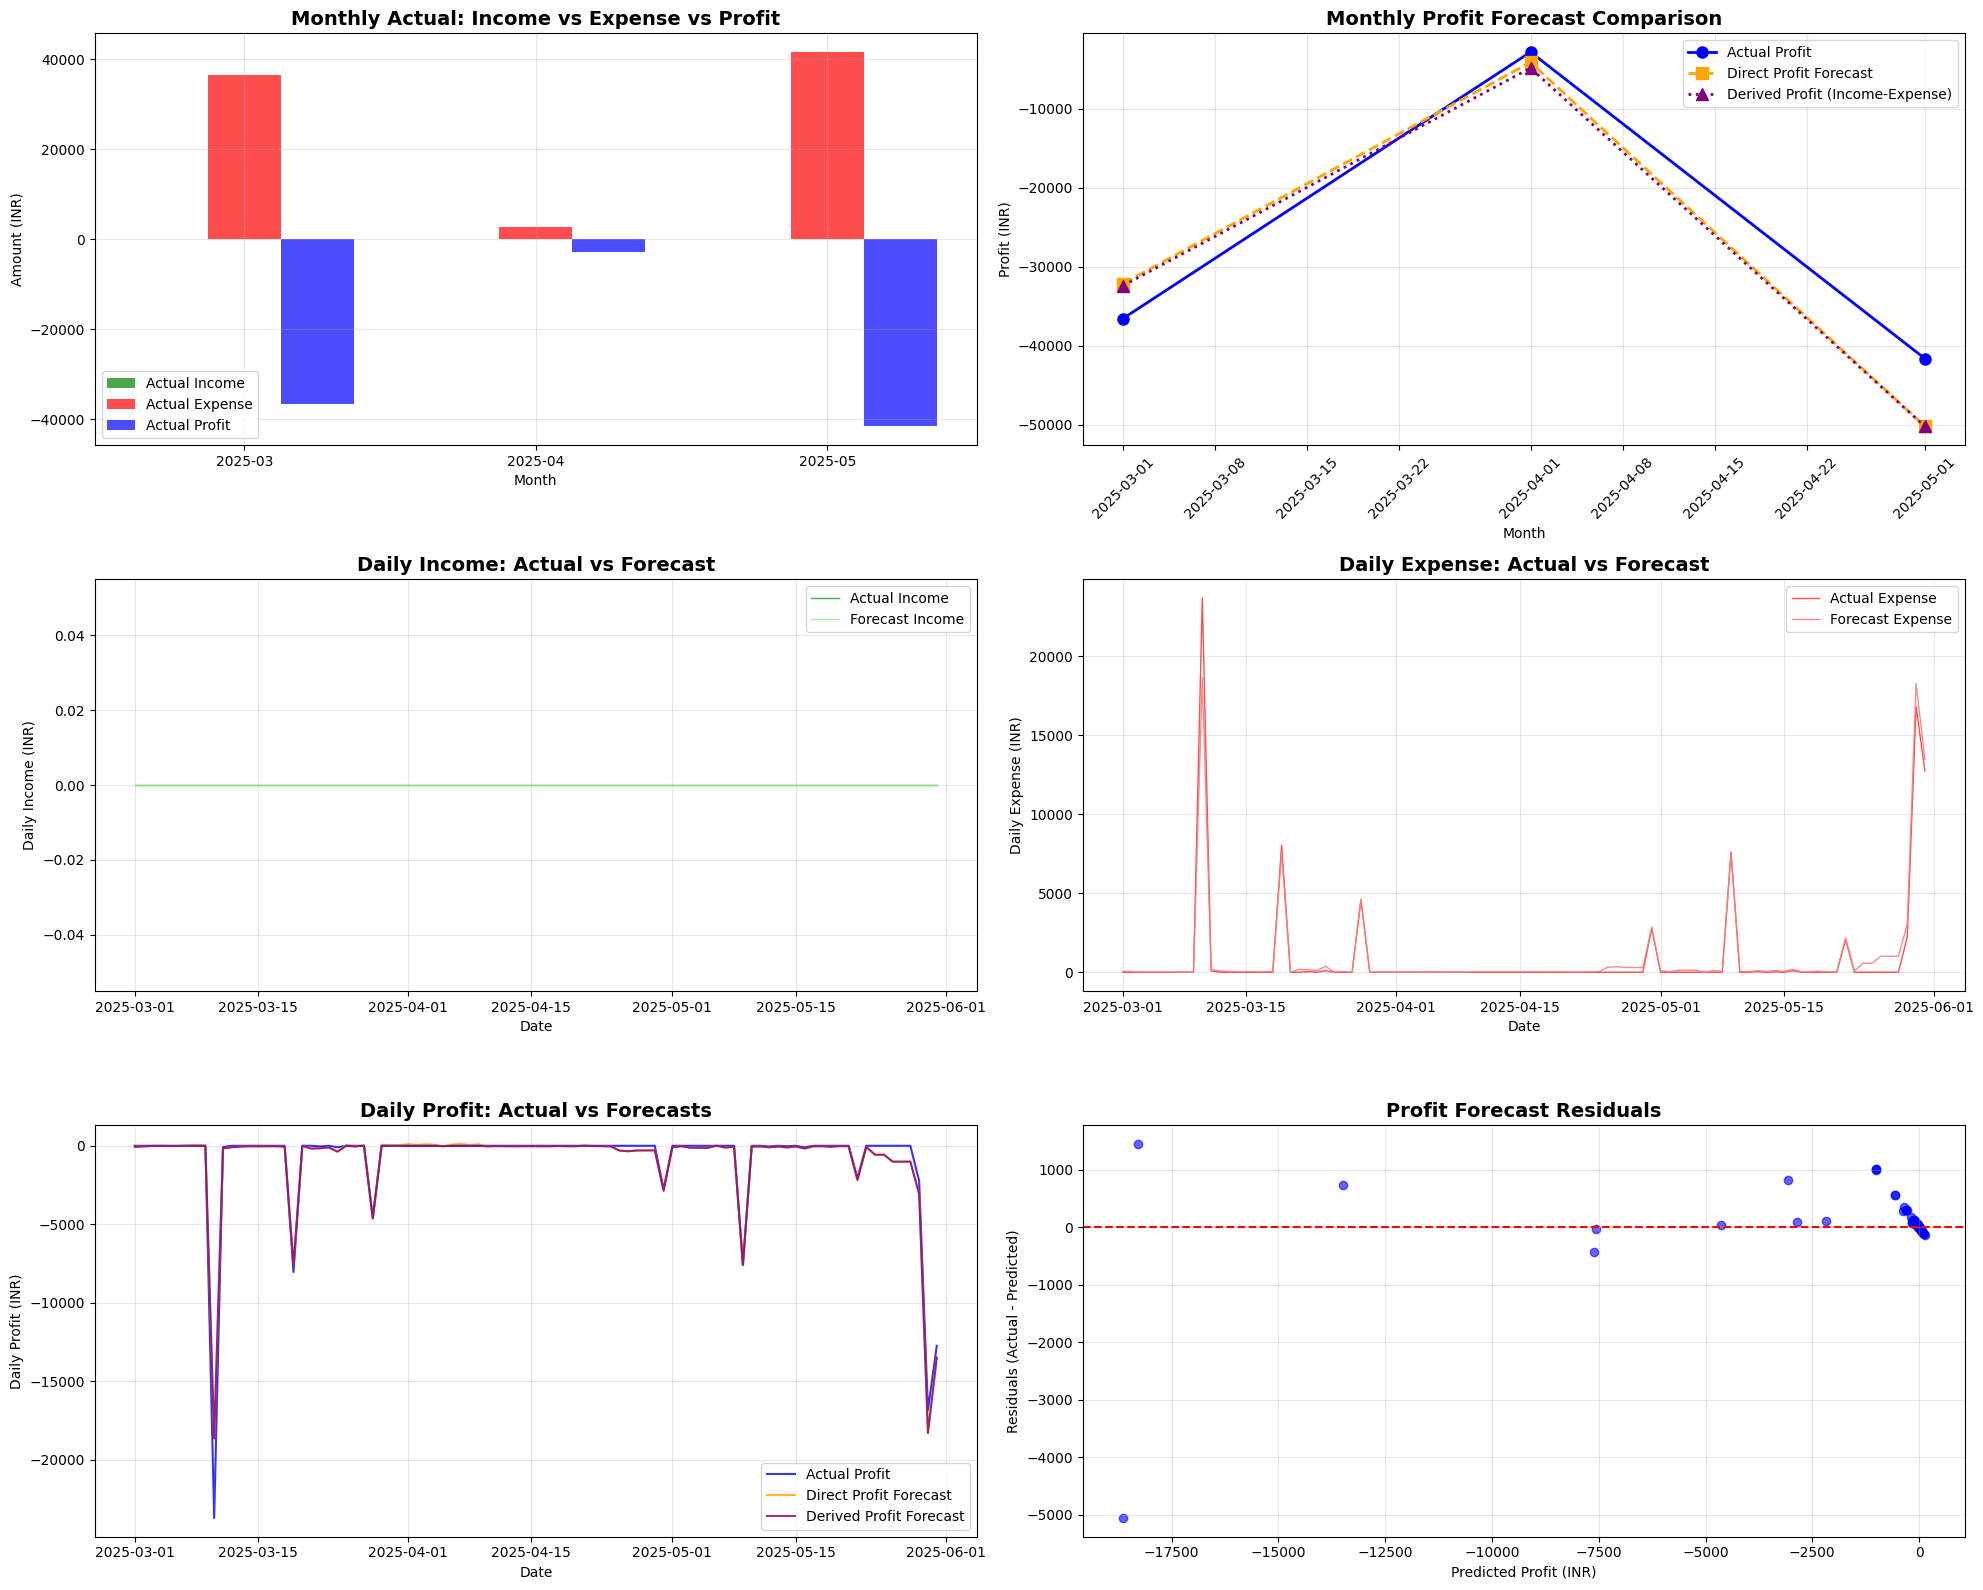


🔍 FEATURE IMPORTANCE ANALYSIS...

📈 Top 15 Most Important Features for Profit Prediction:
                        feature  importance
98                expense_ratio      0.5117
97                profit_margin      0.3329
95    historical_quarter_profit      0.0311
105           expense_growth_7d      0.0191
9                 dayofweek_sin      0.0162
29                expense_lag_7      0.0103
58        expense_rolling_max_7      0.0100
1                         month      0.0067
92   historical_quarter_expense      0.0059
5                     month_sin      0.0054
69       expense_rolling_std_90      0.0044
64      expense_rolling_mean_30      0.0039
17        days_from_month_start      0.0035
0                           day      0.0031
26                expense_lag_1      0.0030


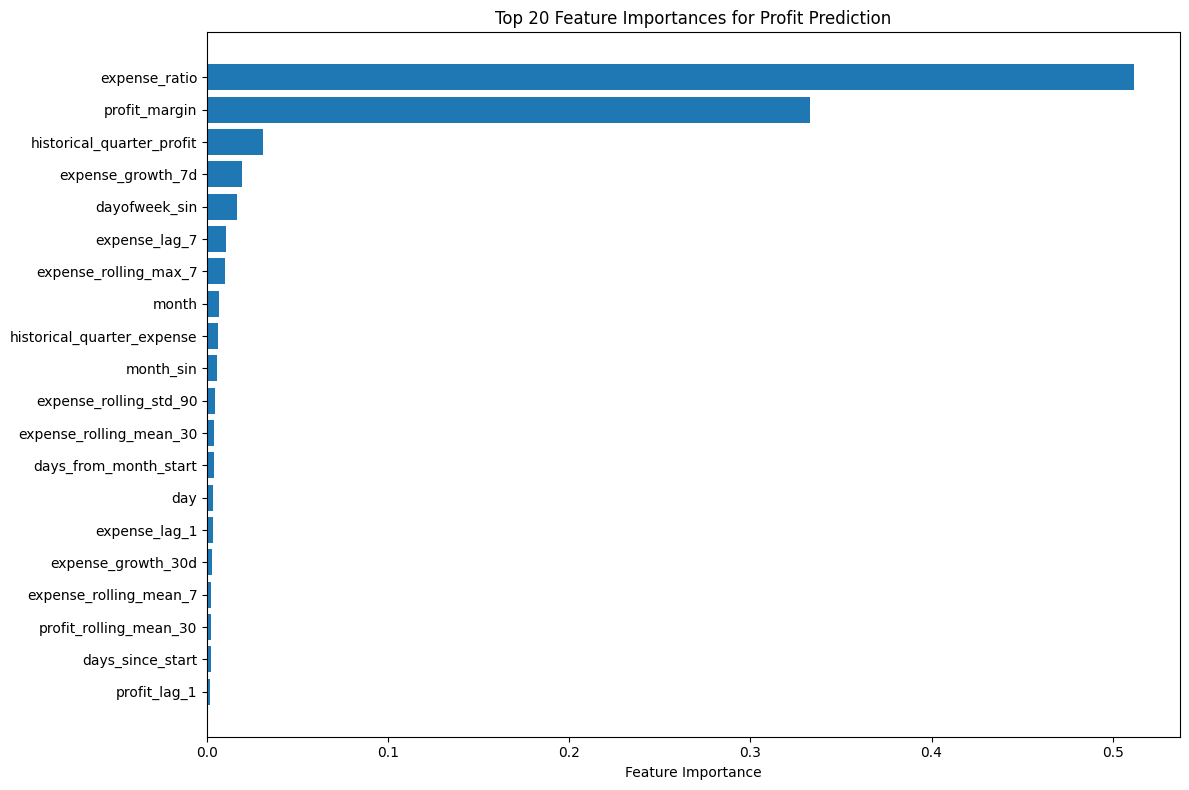


📅 DAILY PROFIT FORECAST SUMMARY
      Date  Actual_Income  Forecast_Income  Actual_Expense  Forecast_Expense  Actual_Profit  Direct_Profit_Forecast  Derived_Profit_Forecast  Profit_Error_%
2025-03-01              0              0.0            0.00         65.430000           0.00              -65.430000               -65.430000            0.00
2025-03-02              0              0.0            0.00         38.900002           0.00              -38.900002               -38.900002            0.00
2025-03-03              0              0.0            0.00         11.670000           0.00              -11.670000               -11.670000            0.00
2025-03-04              0              0.0            0.00          9.250000           0.00               -9.250000                -9.250000            0.00
2025-03-05              0              0.0            0.00         16.520000           0.00              -16.520000               -16.520000            0.00
2025-03-06              0

In [ ]:
# COMBINED INCOME-EXPENSE PROFIT FORECASTING MODEL
# Predicts company profits using XGBoost on both income and expense data

# STEP 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
import sys # Import sys module

warnings.filterwarnings('ignore')

# STEP 2: Load Data (MODIFIED TO HANDLE BOTH CSV AND EXCEL)
print("📂 LOADING DATA...")
file_path = "/content/Predictive_Analytics_Locus.xlsx" # Original file path

df = pd.DataFrame() # Initialize an empty DataFrame

if file_path.lower().endswith('.csv'):
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded CSV file: {file_path}")
    except FileNotFoundError:
        print(f"Error: CSV file '{file_path}' not found. Please check the path.")
    except UnicodeDecodeError:
        print(f"Error: Could not decode CSV file '{file_path}' with default encoding. Trying 'latin1'.")
        try:
            df = pd.read_csv(file_path, encoding='latin1')
            print(f"Successfully loaded CSV file with 'latin1' encoding.")
        except Exception as e:
            print(f"Error loading CSV with 'latin1' encoding: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while loading CSV file: {e}")
elif file_path.lower().endswith('.xlsx') or file_path.lower().endswith('.xls'):
    try:
        # You need to install openpyxl: pip install openpyxl
        df = pd.read_excel(file_path, engine='openpyxl')
        print(f"Successfully loaded Excel file: {file_path}")
    except FileNotFoundError:
        print(f"Error: Excel file '{file_path}' not found. Please check the path.")
    except ImportError:
        print("Error: 'openpyxl' library not found. Please install it: pip install openpyxl")
    except Exception as e:
        print(f"An unexpected error occurred while loading Excel file: {e}")
else:
    print(f"Error: Unsupported file format for '{file_path}'. Please use .csv or .xlsx.")

if df.empty:
    print("❌ Dataframe is empty after loading. Exiting.")
    sys.exit()

print(f"Original DataFrame shape: {df.shape}")
print(f"Original DataFrame columns: {df.columns.tolist()}")

# STEP 3: Process Income Data
print("\n🟢 PROCESSING INCOME DATA...")
income_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Income')].copy()
print(f"Income records: {income_df.shape[0]:,}")

if not income_df.empty:
    # Use errors='coerce' to turn unparseable dates into NaT
    income_df['Transaction Date'] = pd.to_datetime(income_df['Transaction Date'], errors='coerce')
    income_df.dropna(subset=['Transaction Date'], inplace=True)
    income_df['Credit - Debit'] = pd.to_numeric(income_df['Credit - Debit'], errors='coerce')
    income_df.dropna(subset=['Credit - Debit'], inplace=True)

    # Daily income aggregation
    daily_income = income_df.groupby('Transaction Date')['Credit - Debit'].sum().reset_index()
    daily_income.columns = ['ds', 'income']

    # Remove income outliers
    if len(daily_income) > 1 and daily_income['income'].std() > 0: # Check to avoid error on single-row/zero-std data
        mean_income = daily_income['income'].mean()
        std_income = daily_income['income'].std()
        daily_income = daily_income[np.abs(daily_income['income'] - mean_income) <= 3 * std_income].copy()
    else:
        print("Skipping income outlier removal due to insufficient data or zero standard deviation.")

    print(f"Daily income data points: {len(daily_income):,}")
    print(f"Average daily income: ₹{daily_income['income'].mean():,.2f}")
else:
    daily_income = pd.DataFrame(columns=['ds', 'income'])
    print("⚠️ No income data found!")

# STEP 4: Process Expense Data
print("\n🔴 PROCESSING EXPENSE DATA...")
expense_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Expense')].copy()
print(f"Expense records: {expense_df.shape[0]:,}")

if not expense_df.empty:
    expense_df['Transaction Date'] = pd.to_datetime(expense_df['Transaction Date'], errors='coerce')
    expense_df.dropna(subset=['Transaction Date'], inplace=True)
    expense_df['Debit - Credit'] = pd.to_numeric(expense_df['Debit - Credit'], errors='coerce')
    expense_df.dropna(subset=['Debit - Credit'], inplace=True)

    # For expenses, use absolute values
    expense_df['Expense Amount'] = expense_df['Debit - Credit'].abs()

    # Daily expense aggregation
    daily_expense = expense_df.groupby('Transaction Date')['Expense Amount'].sum().reset_index()
    daily_expense.columns = ['ds', 'expense']

    # Remove expense outliers
    if len(daily_expense) > 1 and daily_expense['expense'].std() > 0: # Check to avoid error on single-row/zero-std data
        mean_expense = daily_expense['expense'].mean()
        std_expense = daily_expense['expense'].std()
        daily_expense = daily_expense[np.abs(daily_expense['expense'] - mean_expense) <= 3 * std_expense].copy()
    else:
        print("Skipping expense outlier removal due to insufficient data or zero standard deviation.")

    print(f"Daily expense data points: {len(daily_expense):,}")
    print(f"Average daily expense: ₹{daily_expense['expense'].mean():,.2f}")
else:
    daily_expense = pd.DataFrame(columns=['ds', 'expense'])
    print("⚠️ No expense data found!")

# STEP 5: Combine Income and Expense Data
print("\n💰 COMBINING INCOME & EXPENSE DATA...")

data_available = False
start_date = None
end_date = None

if not daily_income.empty:
    start_date = daily_income['ds'].min()
    end_date = daily_income['ds'].max()
    data_available = True

if not daily_expense.empty:
    if data_available:
        start_date = min(start_date, daily_expense['ds'].min())
        end_date = max(end_date, daily_expense['ds'].max())
    else:
        start_date = daily_expense['ds'].min()
        end_date = daily_expense['ds'].max()
    data_available = True

if not data_available:
    print("❌ No data available for processing income or expense! Cannot combine. Exiting.")
    sys.exit() # Ensure exit happens if no data is found

# Create complete date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
daily_combined = pd.DataFrame({'ds': date_range})

# Merge income and expense data
daily_combined = daily_combined.merge(daily_income, on='ds', how='left')
daily_combined = daily_combined.merge(daily_expense, on='ds', how='left')

# Fill missing values with 0
daily_combined['income'] = daily_combined['income'].fillna(0)
daily_combined['expense'] = daily_combined['expense'].fillna(0)

# Calculate daily profit
daily_combined['profit'] = daily_combined['income'] - daily_combined['expense']

# Check if daily_combined is empty after merging and filling
if daily_combined.empty:
    print("❌ Combined daily data is empty. Cannot proceed with feature engineering or forecasting. Exiting.")
    sys.exit()

print(f"Combined dataset shape: {daily_combined.shape}")
print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Average daily profit: ₹{daily_combined['profit'].mean():,.2f}")
print(f"Total profit in period: ₹{daily_combined['profit'].sum():,.2f}")

# STEP 6: Enhanced Feature Engineering for Profit Prediction
def create_profit_features(df):
    df = df.copy()

    # Basic date features
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter

    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Business calendar features
    df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)
    df['is_fy_end'] = (df['month'] == 3).astype(int)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Days from important dates
    df['days_from_month_start'] = df['day'] - 1
    df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']

    # Lag features for all components
    for component in ['income', 'expense', 'profit']:
        for lag in [1, 2, 3, 7, 14, 30, 90]:
            df[f'{component}_lag_{lag}'] = df[component].shift(lag)

    # Rolling statistics for all components
    for component in ['income', 'expense', 'profit']:
        for window in [7, 14, 30, 90]:
            df[f'{component}_rolling_mean_{window}'] = df[component].rolling(window, min_periods=1).mean().shift(1)
            df[f'{component}_rolling_std_{window}'] = df[component].rolling(window, min_periods=1).std().shift(1)
            df[f'{component}_rolling_max_{window}'] = df[component].rolling(window, min_periods=1).max().shift(1)
            df[f'{component}_rolling_min_{window}'] = df[component].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    for component in ['income', 'expense', 'profit']:
        df[f'historical_month_{component}'] = df.groupby('month')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df[f'historical_quarter_{component}'] = df.groupby('quarter')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df[f'historical_dow_{component}'] = df.groupby('dayofweek')[component].transform(
            lambda x: x.expanding().mean().shift(1)
        )

    # Profit ratios and business metrics
    epsilon = 1e-6
    df['profit_margin'] = df['profit'] / (df['income'] + epsilon)
    df['expense_ratio'] = df['expense'] / (df['income'] + epsilon)

    # Volatility features
    df['profit_volatility_7d'] = df['profit'].rolling(7).std().shift(1)
    df['profit_volatility_30d'] = df['profit'].rolling(30).std().shift(1)
    df['income_volatility_7d'] = df['income'].rolling(7).std().shift(1)
    df['expense_volatility_7d'] = df['expense'].rolling(7).std().shift(1)

    # Growth rates
    for component in ['income', 'expense', 'profit']:
        df[f'{component}_growth_7d'] = ((df[component] / df[component].shift(7).replace(0, np.nan)) - 1) * 100
        df[f'{component}_growth_30d'] = ((df[component] / df[component].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days

    return df

# Apply feature engineering
print("\n🛠️ CREATING FEATURES...")
daily_features = create_profit_features(daily_combined)

# Handle inf and NaN values
daily_features.replace([np.inf, -np.inf], np.nan, inplace=True)
daily_features.fillna(method='bfill', inplace=True)
daily_features.fillna(method='ffill', inplace=True)
daily_features.fillna(0, inplace=True)

print(f"Features created. Dataset shape: {daily_features.shape}")

# STEP 7: Split Train/Test Data
print("\n📊 SPLITTING DATA...")
test_start_date = pd.to_datetime('2025-03-01')
test_end_date = pd.to_datetime('2025-05-31')

train = daily_features[daily_features['ds'] < test_start_date].copy()
test = daily_features[(daily_features['ds'] >= test_start_date) &
                      (daily_features['ds'] <= test_end_date)].copy()

# If no test data in 2025, use last 3 months
if test.empty:
    print("⚠️ No test data for Mar-May 2025, using last 3 months as test set")
    if not daily_features.empty:
        test_start_date = daily_features['ds'].max() - pd.DateOffset(months=3)
        train = daily_features[daily_features['ds'] < test_start_date].copy()
        test = daily_features[daily_features['ds'] >= test_start_date].copy()
    else:
        print("❌ No features data available for splitting. Exiting.")
        sys.exit()

if train.empty or test.empty:
    print("❌ Training or Test dataset is empty after splitting. Cannot proceed with model training.")
    sys.exit()

print(f"Training data: {train.shape[0]:,} days")
print(f"Test data: {test.shape[0]:,} days")
print(f"Test period: {test['ds'].min().strftime('%Y-%m-%d')} to {test['ds'].max().strftime('%Y-%m-%d')}")

# Select features (excluding target variables and date)
feature_cols = [col for col in daily_features.columns
                if col not in ['ds', 'income', 'expense', 'profit']]
print(f"Number of features: {len(feature_cols)}")

# STEP 8: Train Models for Income, Expense, and Profit
print("\n🚀 TRAINING MODELS...")

# Model configuration
model_config = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1
}

# Train individual models
models = {}
for target in ['income', 'expense', 'profit']:
    print(f"Training {target} model...")
    # Ensure all feature columns exist in the training data
    missing_cols = [col for col in feature_cols if col not in train.columns]
    if missing_cols:
        print(f"Warning: Missing columns in train data for {target} model: {missing_cols}")

    models[target] = XGBRegressor(**model_config)
    models[target].fit(train[feature_cols], train[target])

# STEP 9: Make Predictions
print("\n🔮 MAKING PREDICTIONS...")
test_pred = test.copy()

for target in ['income', 'expense', 'profit']:
    test_pred[f'{target}_forecast'] = models[target].predict(test[feature_cols])
    # Ensure non-negative values for income and expense
    if target in ['income', 'expense']:
        test_pred[f'{target}_forecast'] = test_pred[f'{target}_forecast'].clip(lower=0)

# Calculate derived profit from income and expense predictions
test_pred['profit_derived'] = test_pred['income_forecast'] - test_pred['expense_forecast']

# STEP 10: Monthly Aggregation and Metrics
print("\n📈 CALCULATING METRICS...")

def calculate_metrics(actual, forecast, metric_name):
    monthly_actual = actual.groupby(actual.index.to_period('M')).sum()
    monthly_forecast = forecast.groupby(forecast.index.to_period('M')).sum()

    mae = mean_absolute_error(monthly_actual, monthly_forecast)
    rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))

    # Safe MAPE calculation
    mask = monthly_actual != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((monthly_actual[mask] - monthly_forecast[mask]) / monthly_actual[mask])) * 100
    else:
        mape = 0 # If actuals are all zero, MAPE is undefined, set to 0 for consistency
    accuracy = 100 - mape # Accuracy is 100 - MAPE

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': accuracy,
        'Monthly_Actual': monthly_actual,
        'Monthly_Forecast': monthly_forecast
    }

# Calculate metrics for all targets
# Ensure test_pred has 'ds' set as index for time-based operations
if 'ds' in test_pred.columns:
    test_pred.set_index('ds', inplace=True)
elif not isinstance(test_pred.index, pd.DatetimeIndex):
    print("Error: 'ds' column is not set as index or is not a DatetimeIndex in test_pred. Cannot calculate monthly metrics.")
    sys.exit()

metrics = {}

for target in ['income', 'expense', 'profit']:
    # Check if the target column exists in test_pred before calculating metrics
    if target in test_pred.columns and f'{target}_forecast' in test_pred.columns:
        metrics[target] = calculate_metrics(
            test_pred[target],
            test_pred[f'{target}_forecast'],
            target
        )
    else:
        print(f"Skipping metrics for {target}: Actual or forecast column not found in test_pred.")

# Also calculate metrics for derived profit
if 'profit' in test_pred.columns and 'profit_derived' in test_pred.columns:
    metrics['profit_derived'] = calculate_metrics(
        test_pred['profit'],
        test_pred['profit_derived'],
        'profit_derived'
    )
else:
    print("Skipping metrics for derived profit: Actual profit or derived profit column not found in test_pred.")


# STEP 11: Display Results
print("\n" + "="*60)
print("📊 FORECAST ACCURACY RESULTS")
print("="*60)

if not metrics:
    print("No metrics to display. Exiting.")
    sys.exit()

for target, metric in metrics.items():
    print(f"\n🎯 {target.upper()} FORECAST:")
    print(f"    MAE: ₹{metric['MAE']:,.2f}")
    print(f"    RMSE: ₹{metric['RMSE']:,.2f}")
    print(f"    MAPE: {metric['MAPE']:.2f}%")
    print(f"    ✅ Accuracy: {metric['Accuracy']:.2f}%")

# STEP 12: Create Comprehensive Comparison Tables
print("\n" + "="*80)
print("📋 MONTHLY FORECAST COMPARISON")
print("="*80)

# Monthly comparison table - ensure all expected keys exist in metrics
monthly_comparison_data = {}
has_profit_data = False
if 'income' in metrics:
    monthly_comparison_data['Actual_Income'] = metrics['income']['Monthly_Actual']
    monthly_comparison_data['Forecast_Income'] = metrics['income']['Monthly_Forecast']
if 'expense' in metrics:
    monthly_comparison_data['Actual_Expense'] = metrics['expense']['Monthly_Actual']
    monthly_comparison_data['Forecast_Expense'] = metrics['expense']['Monthly_Forecast']
if 'profit' in metrics:
    monthly_comparison_data['Actual_Profit'] = metrics['profit']['Monthly_Actual']
    monthly_comparison_data['Forecast_Profit'] = metrics['profit']['Monthly_Forecast']
    has_profit_data = True
if 'profit_derived' in metrics:
    monthly_comparison_data['Derived_Profit'] = metrics['profit_derived']['Monthly_Forecast']
    has_profit_data = True # If derived profit is available, we also have some profit context

if not monthly_comparison_data:
    print("No monthly comparison data to display. Skipping table and visualizations.")
    # Exit if there's no data to plot, otherwise the plotting steps will fail.
    sys.exit()

monthly_comparison = pd.DataFrame(monthly_comparison_data)

if has_profit_data and 'Actual_Profit' in monthly_comparison.columns and 'Forecast_Profit' in monthly_comparison.columns:
    monthly_comparison['Profit_Error'] = monthly_comparison['Actual_Profit'] - monthly_comparison['Forecast_Profit']
    # Use .replace to avoid division by zero if Actual_Profit is 0
    monthly_comparison['Profit_Error_%'] = (monthly_comparison['Profit_Error'].abs() /
                                            monthly_comparison['Actual_Profit'].abs().replace(0, np.nan)) * 100
else:
    print("Not enough profit data for detailed error analysis in monthly comparison.")
    if 'Profit_Error' in monthly_comparison.columns:
        monthly_comparison.drop(columns=['Profit_Error'], inplace=True)
    if 'Profit_Error_%' in monthly_comparison.columns:
        monthly_comparison.drop(columns=['Profit_Error_%'], inplace=True)


print(monthly_comparison.round(2))

# STEP 13: Comprehensive Visualizations
print("\n🎨 CREATING VISUALIZATIONS...")

# Only create plots if there is data in monthly_comparison
if monthly_comparison.empty and test_pred.empty:
    print("No data available for plotting. Skipping visualizations.")
else:
    # Create comprehensive plots
    fig = plt.figure(figsize=(20, 16))

    # 1. Monthly Overview
    ax1 = plt.subplot(3, 2, 1)
    x = range(len(monthly_comparison))
    width = 0.25

    if 'Actual_Income' in monthly_comparison.columns:
        plt.bar([i - width for i in x], monthly_comparison['Actual_Income'], width,
                label='Actual Income', color='green', alpha=0.7)
    if 'Actual_Expense' in monthly_comparison.columns:
        plt.bar(x, monthly_comparison['Actual_Expense'], width,
                label='Actual Expense', color='red', alpha=0.7)
    if 'Actual_Profit' in monthly_comparison.columns:
        plt.bar([i + width for i in x], monthly_comparison['Actual_Profit'], width,
                label='Actual Profit', color='blue', alpha=0.7)

    plt.title('Monthly Actual: Income vs Expense vs Profit', fontsize=14, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Amount (INR)')
    plt.xticks(x, [str(idx)[:7] for idx in monthly_comparison.index])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Profit Forecast Comparison
    ax2 = plt.subplot(3, 2, 2)
    if 'Actual_Profit' in monthly_comparison.columns:
        plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Actual_Profit'],
                 'o-', label='Actual Profit', color='blue', linewidth=2, markersize=8)
    if 'Forecast_Profit' in monthly_comparison.columns:
        plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Forecast_Profit'],
                 's--', label='Direct Profit Forecast', color='orange', linewidth=2, markersize=8)
    if 'Derived_Profit' in monthly_comparison.columns:
        plt.plot(monthly_comparison.index.to_timestamp(), monthly_comparison['Derived_Profit'],
                 '^:', label='Derived Profit (Income-Expense)', color='purple', linewidth=2, markersize=8)

    plt.title('Monthly Profit Forecast Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Profit (INR)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # 3. Daily Income Forecast
    ax3 = plt.subplot(3, 2, 3)
    if 'income' in test_pred.columns and 'income_forecast' in test_pred.columns:
        plt.plot(test_pred.index, test_pred['income'], label='Actual Income',
                 color='green', alpha=0.7, linewidth=1)
        plt.plot(test_pred.index, test_pred['income_forecast'], label='Forecast Income',
                 color='lightgreen', alpha=0.9, linewidth=1)
    plt.title('Daily Income: Actual vs Forecast', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Daily Income (INR)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Daily Expense Forecast
    ax4 = plt.subplot(3, 2, 4)
    if 'expense' in test_pred.columns and 'expense_forecast' in test_pred.columns:
        plt.plot(test_pred.index, test_pred['expense'], label='Actual Expense',
                 color='red', alpha=0.7, linewidth=1)
        plt.plot(test_pred.index, test_pred['expense_forecast'], label='Forecast Expense',
                 color='lightcoral', alpha=0.9, linewidth=1)
    plt.title('Daily Expense: Actual vs Forecast', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Daily Expense (INR)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Daily Profit Forecast
    ax5 = plt.subplot(3, 2, 5)
    if 'profit' in test_pred.columns:
        plt.plot(test_pred.index, test_pred['profit'], label='Actual Profit',
                 color='blue', alpha=0.8, linewidth=1.5)
    if 'profit_forecast' in test_pred.columns:
        plt.plot(test_pred.index, test_pred['profit_forecast'], label='Direct Profit Forecast',
                 color='orange', alpha=0.8, linewidth=1.5)
    if 'profit_derived' in test_pred.columns:
        plt.plot(test_pred.index, test_pred['profit_derived'], label='Derived Profit Forecast',
                 color='purple', alpha=0.8, linewidth=1.5)
    plt.title('Daily Profit: Actual vs Forecasts', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Daily Profit (INR)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 6. Profit Forecast Accuracy (Residuals)
    ax6 = plt.subplot(3, 2, 6)
    if 'profit' in test_pred.columns and 'profit_forecast' in test_pred.columns:
        profit_residuals = test_pred['profit'] - test_pred['profit_forecast']
        plt.scatter(test_pred['profit_forecast'], profit_residuals, alpha=0.6, color='blue')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Profit Forecast Residuals', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Profit (INR)')
        plt.ylabel('Residuals (Actual - Predicted)')
        plt.grid(True, alpha=0.3)
    else:
        plt.title('Profit Forecast Residuals (Data Unavailable)', fontsize=14, fontweight='bold')
        plt.text(0.5, 0.5, "Not enough data for residuals plot",
                 horizontalalignment='center', verticalalignment='center', transform=ax6.transAxes)


    plt.tight_layout()
    plt.show()

# STEP 14: Feature Importance Analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS...")

# Get feature importance for profit model
if 'profit' in models and feature_cols: # Ensure model exists and features were defined
    profit_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': models['profit'].feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n📈 Top 15 Most Important Features for Profit Prediction:")
    print(profit_importance.head(15).round(4))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = profit_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances for Profit Prediction')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Skipping feature importance analysis: Profit model not trained or no features available.")

# STEP 15: Daily Forecast Summary Table
print("\n" + "="*100)
print("📅 DAILY PROFIT FORECAST SUMMARY")
print("="*100)

# Check if test_pred is empty before creating the summary table
if test_pred.empty:
    print("No daily forecast summary data available.")
else:
    daily_summary = test_pred[['income', 'income_forecast', 'expense', 'expense_forecast',
                               'profit', 'profit_forecast', 'profit_derived']].copy()
    daily_summary.reset_index(inplace=True)
    daily_summary['Profit_Error_%'] = np.where(
        daily_summary['profit'] == 0, 0,
        ((daily_summary['profit_forecast'] - daily_summary['profit']) / daily_summary['profit'].abs()) * 100
    )

    # Rename columns for better readability
    daily_summary.columns = [
        'Date', 'Actual_Income', 'Forecast_Income', 'Actual_Expense', 'Forecast_Expense',
        'Actual_Profit', 'Direct_Profit_Forecast', 'Derived_Profit_Forecast', 'Profit_Error_%'
    ]

    # Round values
    daily_summary = daily_summary.round({
        'Actual_Income': 2, 'Forecast_Income': 2, 'Actual_Expense': 2, 'Forecast_Expense': 2,
        'Actual_Profit': 2, 'Direct_Profit_Forecast': 2, 'Derived_Profit_Forecast': 2, 'Profit_Error_%': 2
    })

    print(daily_summary.to_string(index=False))

print("\n" + "="*60)
print("🎊 PROFIT FORECASTING ANALYSIS COMPLETE!")
print("="*60)

# Final summary checks
if 'profit' in metrics and 'profit_derived' in metrics:
    print(f"✅ Best Profit Forecast Accuracy: {max(metrics['profit']['Accuracy'], metrics['profit_derived']['Accuracy']):.2f}%")
    print(f"📊 Total Test Period Profit: ₹{test_pred['profit'].sum():,.2f}")
    print(f"🔮 Total Forecasted Profit: ₹{test_pred['profit_forecast'].sum():,.2f}")
    print(f"💰 Forecast vs Actual Difference: ₹{(test_pred['profit_forecast'].sum() - test_pred['profit'].sum()):,.2f}")
else:
    print("No profit metrics available for final summary.")